# Predicting Taxi Travel Time & Late Risk for NYC Airport Trips

## Team Members: Abhay Puri, Andrew Chen, Andrew White, Lena Weissman, Riju Hariharan

In [58]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
import statsmodels.formula.api as smf
import statsmodels.stats.api as sms


### Load and Explore the Taxi and Zone Data

In [3]:
# Load Data
taxi = pd.read_csv('taxi_data.csv')
zones = pd.read_csv('taxi_zone_lookup.csv')

taxi.head()
# zones.head()

/var/folders/qk/vdr0dvt91yj5p8tdhjkrzflh0000gn/T/ipykernel_28546/3841997831.py:2: DtypeWarning: Columns (6) have mixed types. Specify dtype option on import or set low_memory=False.
  taxi = pd.read_csv('taxi_data.csv')


,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,fare_amount,extra,mta_tax,tip_amount,tolls_amount,improvement_surcharge,total_amount,congestion_surcharge,Airport_fee,cbd_congestion_fee
0,2,2025-08-01 00:52:23,2025-08-01 01:12:20,1.0,8.44,1.0,N,138,141,1,33.8,6.0,0.5,5.00,6.94,1.0,57.49,2.5,1.75,0.00
1,2,2025-08-01 00:03:01,2025-08-01 00:15:33,2.0,4.98,1.0,N,138,193,1,21.2,6.0,0.5,0.00,0.00,1.0,30.45,0.0,1.75,0.00
2,7,2025-08-01 00:24:38,2025-08-01 00:24:38,2.0,1.89,1.0,N,249,45,1,14.2,0.0,0.5,3.99,0.00,1.0,23.94,2.5,0.00,0.75
3,7,2025-08-01 00:48:19,2025-08-01 00:48:19,1.0,2.35,1.0,N,79,229,1,11.4,0.0,0.5,3.43,0.00,1.0,20.58,2.5,0.00,0.75
4,2,2025-08-01 00:25:34,2025-08-01 00:33:18,1.0,2.14,1.0,N,43,48,1,11.4,1.0,0.5,2.57,0.00,1.0,19.72,2.5,0.00,0.75


#### Explore Data Types

In [4]:
# Data types    
print(taxi.dtypes)
print("--------------------------------")
print("--------------------------------")
print(zones.dtypes)

VendorID                   int64
tpep_pickup_datetime      object
tpep_dropoff_datetime     object
passenger_count          float64
trip_distance            float64
RatecodeID               float64
store_and_fwd_flag        object
PULocationID               int64
DOLocationID               int64
payment_type               int64
fare_amount              float64
extra                    float64
mta_tax                  float64
tip_amount               float64
tolls_amount             float64
improvement_surcharge    float64
total_amount             float64
congestion_surcharge     float64
Airport_fee              float64
cbd_congestion_fee       float64
dtype: object
--------------------------------
--------------------------------
LocationID       int64
Borough         object
Zone            object
service_zone    object
dtype: object


#### Explore Missing Values

In [5]:
# Missing values for taxi data
taxi.isnull().sum()

VendorID                      0
tpep_pickup_datetime          0
tpep_dropoff_datetime         0
passenger_count          886234
trip_distance                 0
RatecodeID               886234
store_and_fwd_flag       886234
PULocationID                  0
DOLocationID                  0
payment_type                  0
fare_amount                   0
extra                         0
mta_tax                       0
tip_amount                    0
tolls_amount                  0
improvement_surcharge         0
total_amount                  0
congestion_surcharge     886234
Airport_fee              886234
cbd_congestion_fee            0
dtype: int64

In [6]:
# Missing values for zones data
zones.isnull().sum()

LocationID      0
Borough         1
Zone            1
service_zone    2
dtype: int64

### Convert the Date and Time to timesereies data. Also convert trip duration to minutes and create new column to explore

In [7]:
# Convert pickup and dropoff to datetime
taxi["tpep_pickup_datetime"] = pd.to_datetime(taxi["tpep_pickup_datetime"])
taxi["tpep_dropoff_datetime"] = pd.to_datetime(taxi["tpep_dropoff_datetime"])

# Trip duration in minutes
taxi["duration_min"] = ((taxi["tpep_dropoff_datetime"] - taxi["tpep_pickup_datetime"]).dt.total_seconds() / 60).round(2)
taxi[["tpep_pickup_datetime", "tpep_dropoff_datetime", "duration_min"]].head()

,tpep_pickup_datetime,tpep_dropoff_datetime,duration_min
0,2025-08-01 00:52:23,2025-08-01 01:12:20,19.95
1,2025-08-01 00:03:01,2025-08-01 00:15:33,12.53
2,2025-08-01 00:24:38,2025-08-01 00:24:38,0.00
3,2025-08-01 00:48:19,2025-08-01 00:48:19,0.00
4,2025-08-01 00:25:34,2025-08-01 00:33:18,7.73


### Identify the Airport Zones and the Manhattan Zones we are working with

In [8]:
# Look at airport zones
airports_lookup = zones[zones["Zone"].str.contains("Airport", case=False, na=False)]
print(airports_lookup)

# Get the IDs of the airports
JFK_ID = 132
LGA_ID = 138 
airport_ids = [JFK_ID, LGA_ID]   

# All Manhattan pickup zones with LocationID and Zone
manhattan_zones = zones.loc[zones["Borough"] == "Manhattan", ["LocationID","Zone"]].copy()
manhattan_ids = manhattan_zones["LocationID"].tolist()


     LocationID Borough               Zone service_zone
0             1     EWR     Newark Airport          EWR
131         132  Queens        JFK Airport     Airports
137         138  Queens  LaGuardia Airport     Airports


Because we are only focusing on rides to airports, we will keep only trips to JFK and LGA. And because we are only focusing on Manhattan zones, we will only keep the 69 Manhattan Zones

In [9]:
# View the zones and IDs
manhattan_zones.head()
len(manhattan_zones)

69

### Outlier Detection and Removal

##### Restricted the data to trips from Manhattan to JFK or LaGuardia, which gave us about 50,297 rides. Trip durations ranged from 0 minutes to roughly 1,438 minutes (24 hoursish), which is clearly unrealistic for an airport trip. The raw histogram shows a heavy right tail driven by these extreme values.

Manhattan to JFK/LGA trips (before outlier removal): (50297, 21)
count    50297.000000
mean        40.450301
std         33.437770
min          0.000000
25%         26.170000
50%         35.970000
75%         52.220000
max       1437.970000
Name: duration_min, dtype: float64


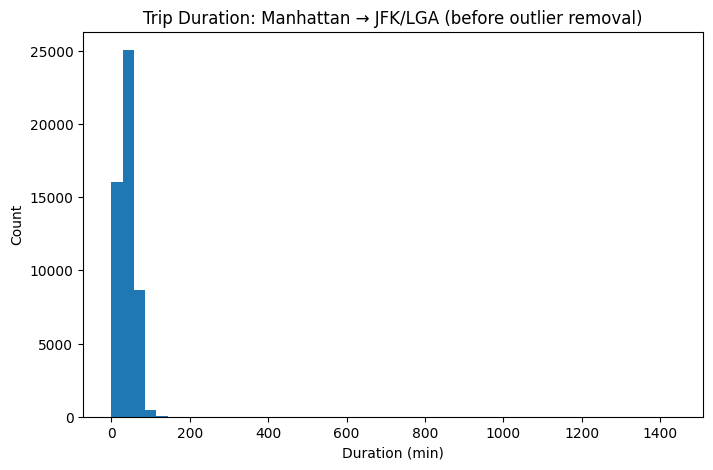

In [10]:
import matplotlib.pyplot as plt

# Manhattan to JFK/LGA only
mask = taxi["PULocationID"].isin(manhattan_ids) & taxi["DOLocationID"].isin(airport_ids)
taxi_ma = taxi[mask]
print("Manhattan to JFK/LGA trips (before outlier removal):", taxi_ma.shape)

# Look at the durations
print(taxi_ma["duration_min"].describe())

# Plot duration distribution to spot outliers, zooming in to more relevant duration range
plt.figure(figsize=(8,5))
plt.hist(taxi_ma["duration_min"], bins=50)
plt.title("Trip Duration: Manhattan → JFK/LGA (before outlier removal)")
plt.xlabel("Duration (min)")
plt.ylabel("Count")
plt.show()

Trips with duration <=3 or >=180: 696
After outlier removal: (49601, 21)
Duration stats after outlier removal
count    49601.000000
mean        40.277613
std         17.444374
min          3.620000
25%         26.500000
50%         36.280000
75%         52.420000
max        179.850000
Name: duration_min, dtype: float64


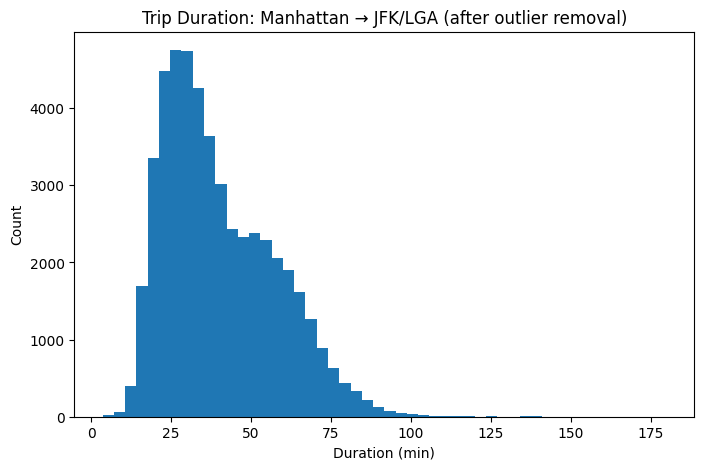

In [11]:
# Outlier mask
mask_outliers = (taxi_ma["duration_min"] <= 3) | (taxi_ma["duration_min"] >= 180)
print("Trips with duration <=3 or >=180:", mask_outliers.sum())

# Drop outliers into a new DF to see what's going on
taxi_clean = taxi_ma.loc[~mask_outliers].copy()
print("After outlier removal:", taxi_clean.shape)

# Replace the old taxi DF with the cleaned 
taxi = taxi_clean

# Show descriptive statistics after outlier removal
print("Duration stats after outlier removal")
print(taxi["duration_min"].describe())

# Plot histogram after outlier removal
plt.figure(figsize=(8,5))
plt.hist(taxi["duration_min"], bins=50)
plt.title("Trip Duration: Manhattan → JFK/LGA (after outlier removal)")
plt.xlabel("Duration (min)")
plt.ylabel("Count")
plt.show()


##### To remove likely trip errors and non standard rides (multi stop, etc.) I treated trips shorter than 3 minutes or longer than 180 minutes as outliers. This affected 696 trips (only about 1.4% of the data), leaving us with 49,601 rides for modeling. The cleaned distribution still has a right tail, but now reflects plausible airport travel times.

In [12]:
# Add pickup zone name to the cleaned taxi data
taxi = taxi.merge(
    manhattan_zones.rename(columns={"LocationID": "PULocationID",
                                    "Zone": "pickup_zone"}),
    on="PULocationID",
    how="left"
)

# Quick check
taxi[["PULocationID", "pickup_zone", "DOLocationID", "duration_min"]].head()


,PULocationID,pickup_zone,DOLocationID,duration_min
0,230,Times Sq/Theatre District,132,31.47
1,230,Times Sq/Theatre District,132,31.47
2,164,Midtown South,132,29.30
3,224,Stuy Town/Peter Cooper Village,132,28.87
4,48,Clinton East,132,31.57


### Time Features and Airport Labels

In [13]:
# Hour of day and day of week
taxi["hour"] = taxi["tpep_pickup_datetime"].dt.hour
taxi["day_of_week"] = taxi["tpep_pickup_datetime"].dt.dayofweek

# Map airport ID to readable name
airport_map = {JFK_ID: "JFK", LGA_ID: "LGA"}
taxi["airport"] = taxi["DOLocationID"].map(airport_map)

# Quick check
taxi[["PULocationID", "pickup_zone", "DOLocationID", "airport", "hour", "day_of_week", "duration_min"]].head()


,PULocationID,pickup_zone,DOLocationID,airport,hour,day_of_week,duration_min
0,230,Times Sq/Theatre District,132,JFK,0,4,31.47
1,230,Times Sq/Theatre District,132,JFK,0,4,31.47
2,164,Midtown South,132,JFK,0,4,29.30
3,224,Stuy Town/Peter Cooper Village,132,JFK,1,4,28.87
4,48,Clinton East,132,JFK,2,4,31.57


In [14]:
# Baseline which is the median duration by pickup zone, airport, hour.
baseline = (taxi.groupby(["PULocationID", "airport", "hour"])["duration_min"].median().rename("median_duration").reset_index())
baseline.head()

# Merge baseline back into main df
taxi = taxi.merge(
    baseline,
    on=["PULocationID", "airport", "hour"],
    how="left")

# Defining late as more than 20% longer than median for that zone+airport+hour
taxi["late"] = (taxi["duration_min"] > 1.2 * taxi["median_duration"]).astype(int)
taxi.head()

,VendorID,tpep_pickup_datetime,tpep_dropoff_datetime,passenger_count,trip_distance,RatecodeID,store_and_fwd_flag,PULocationID,DOLocationID,payment_type,...,congestion_surcharge,Airport_fee,cbd_congestion_fee,duration_min,pickup_zone,hour,day_of_week,airport,median_duration,late
0,2,2025-08-01 00:40:36,2025-08-01 01:12:04,3.0,17.09,2.0,N,230,132,4,...,-2.5,0.0,-0.75,31.47,Times Sq/Theatre District,0,4,JFK,31.47,0
1,2,2025-08-01 00:40:36,2025-08-01 01:12:04,3.0,17.09,2.0,N,230,132,4,...,2.5,0.0,0.75,31.47,Times Sq/Theatre District,0,4,JFK,31.47,0
2,2,2025-08-01 00:18:05,2025-08-01 00:47:23,1.0,17.16,2.0,N,164,132,2,...,2.5,0.0,0.75,29.30,Midtown South,0,4,JFK,29.30,0
3,2,2025-08-01 01:08:09,2025-08-01 01:37:01,1.0,17.63,2.0,N,224,132,1,...,2.5,0.0,0.75,28.87,Stuy Town/Peter Cooper Village,1,4,JFK,28.87,0
4,2,2025-08-01 02:00:39,2025-08-01 02:32:13,1.0,17.61,2.0,N,48,132,2,...,2.5,0.0,0.75,31.57,Clinton East,2,4,JFK,32.72,0


### Late Class Balance

In [15]:
# Check balance of late class
taxi["late"].value_counts(normalize=True)
taxi.groupby("airport")["late"].value_counts(normalize=True)

airport  late
JFK      0       0.853124
         1       0.146876
LGA      0       0.831227
         1       0.168773
Name: proportion, dtype: float64

Overall Late Rate is roughly 16% of trips. We can see that 14.68% of trips going to JFK are considered late. And  16.88% of trips going to LGA are considered late. 

- About 1 in 6 trips is considered "late" under the 20% over the median rule that we set. 
- LGA has a slightly higher late rate than JFK does. This suggests that traffic patterns and distance to LGA produce more variability. 


This is a slightly imbalanced dataset (84% on time vs 16% late). Therefore, when modeling, we will not want to look at accuracy alone. A simple "always on time" model could achieve 84% accuracy but really not be telling us the full truth. We will want to focus on AUC and recall and precision for the late class.


### Distribution of Trip Duration

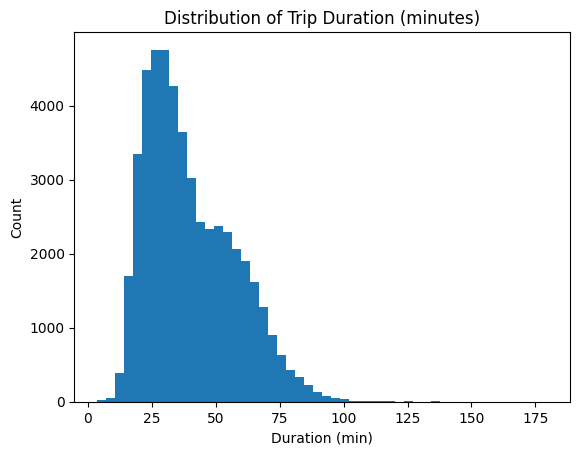

In [16]:
# Distribution of Trip Duration
plt.hist(taxi["duration_min"], bins=50)
plt.title("Distribution of Trip Duration (minutes)")
plt.xlabel("Duration (min)")
plt.ylabel("Count")
plt.show()

- Most airport trips are 30–60 minutes, but there is a noticeable right tail which could represent heavy traffic days and certain traffic related incidents. 

- Long but reasonable tail out to about 150–170 minutes for the rare heavy traffic. This is what our late label is trying to capture, the trips that take much longer than the baseline. 

- There are very few trips below 15-20 minutes, which makes sense because Manhattan to the airport desitinations is not very close.


### Trip Duration by Airport

<Figure size 600x500 with 0 Axes>

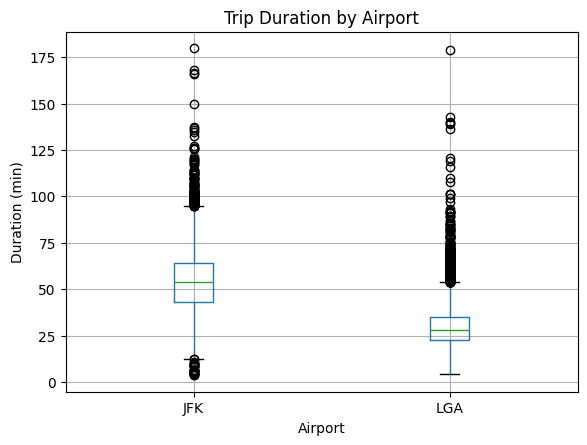

In [17]:
import matplotlib.pyplot as plt

plt.figure(figsize=(6, 5))
taxi.boxplot(column="duration_min", by="airport")
plt.title("Trip Duration by Airport")
plt.suptitle("")  
plt.xlabel("Airport")
plt.ylabel("Duration (min)")
plt.show()

- JFK Median duration time is higher than LGAs.

- JFK has a slightly wider box, which indicates more variability in typical trip duration times for JFK compared to LGA.

- Both JFK and LGA have lots of data points OVER the box, but that makes sense due to distance and factors such as traffic, weather, delays. 

- The different airports, JFK and LGA show that they will be predictive of duration and lateness. 

### Average Trip Duration by Hour and Airport

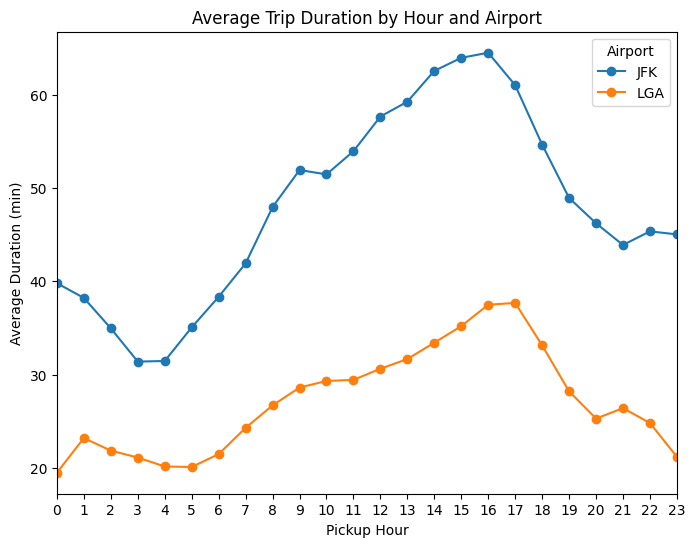

In [18]:
import matplotlib.pyplot as plt

# Average duration by pickup hour and airport
avg_by_hour = (taxi.groupby(["hour", "airport"])["duration_min"].mean().reset_index().sort_values("hour"))

fig, ax = plt.subplots(figsize=(8, 6))

# One line per airport
for airport, grp in avg_by_hour.groupby("airport"):
    ax.plot(grp["hour"], grp["duration_min"], marker="o", label=airport)

# Plot 
ax.set_title("Average Trip Duration by Hour and Airport")
ax.set_xlabel("Pickup Hour")
ax.set_ylabel("Average Duration (min)")
ax.set_xticks(range(0, 24))   # 0–23
ax.set_xlim(0, 23)
ax.legend(title="Airport")
plt.show()


- Late night (0–4): Trips gradually get faster as traffic thins out.

- Early morning (5–9): Durations pick up quickly, which makes sense due to the classic morning rush.

- Late morning to mid-afternoon (10–16): The durations keep climbing, reaching the highest levels around 3–5 PM, meaning heavy traffic in the rush hour time.

- Evening (17–23): Times decline as we move into later hours, but they don’t return all the way to overnight levels.

- JFK is consistently about 10–20 minutes slower than LGA at almost every hour, and its peak is higher, indicating that trips to JFK are both longer on average and more sensitive to rush hour traffic.

- Time of day is definetely a strong predicter of trip duration and in return, if the trip is late or not.

- **Modeling:** We should include hour, and maybe one-hot encode each hour. We could also look into including an interaction between hour and airport when not using tree models (tree models will automatically learn and split these). 
    - We could also think of adding a feature like "is in rush hour" and be 0/1. This could help capture more patterns. 

### Average Trip Duration by Day of Week 

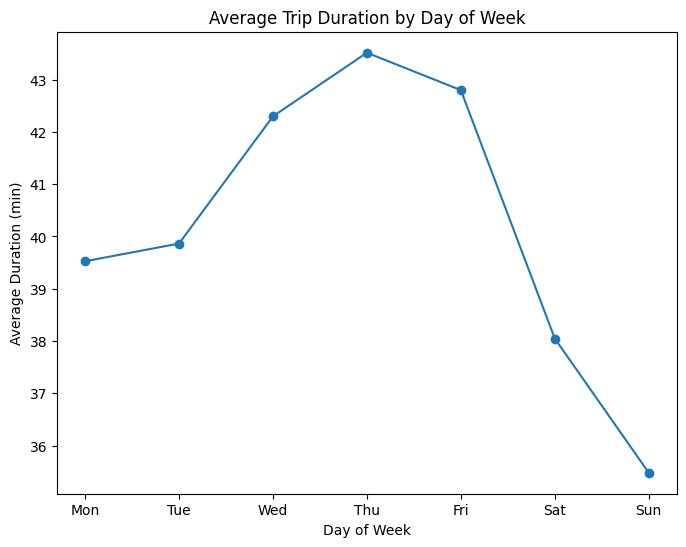

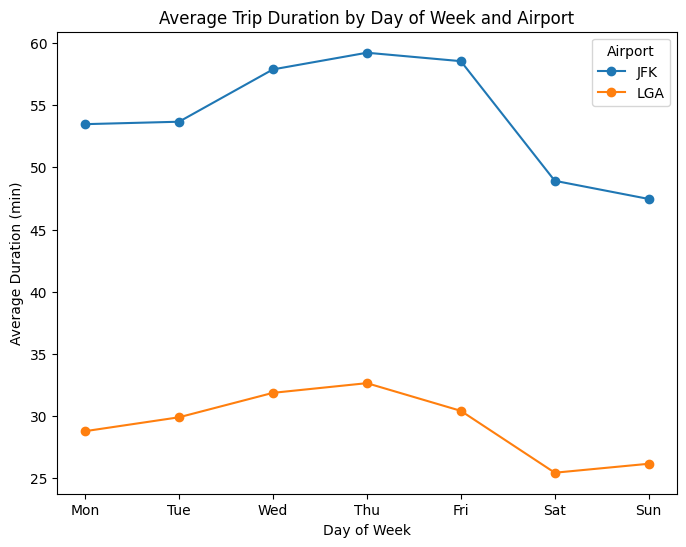

In [19]:
avg_by_day = (taxi.groupby("day_of_week")["duration_min"].mean().reset_index())

plt.figure(figsize=(8, 6))
plt.plot(avg_by_day["day_of_week"], avg_by_day["duration_min"], marker="o")
plt.title("Average Trip Duration by Day of Week")
plt.xlabel("Day of Week")
plt.ylabel("Average Duration (min)")
plt.xticks(range(0, 7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.show()


# Average trip duration by day of week and airport
avg_by_day_airport = (taxi.groupby(["day_of_week", "airport"])["duration_min"].mean().reset_index())

plt.figure(figsize=(8, 6))
for airport, grp in avg_by_day_airport.groupby("airport"):
    plt.plot(grp["day_of_week"], grp["duration_min"], marker="o", label=airport)
plt.title("Average Trip Duration by Day of Week and Airport")
plt.xlabel("Day of Week")
plt.ylabel("Average Duration (min)")
plt.xticks(range(0, 7), ["Mon", "Tue", "Wed", "Thu", "Fri", "Sat", "Sun"])
plt.legend(title="Airport")
plt.show()


- Weekdays have slightly higher average trip durations than weekends. 
- Thursday and Friday seem to be the highest trip duration days which could be a combindation of people elaving for weekend trips or combination of work traffic. 
- JFK again has a higher baseline than LGA across all days 

- The different day of the week is capturing significant patterns with more people driving on the weekdays and different type of drivers (people going to work, leisure, etc.)

- **Modeling:** Day of the week is an important feature. We should include it in the model and one-hot encode each day or split into weekday vs weekend. 

### Late Rate by Hour

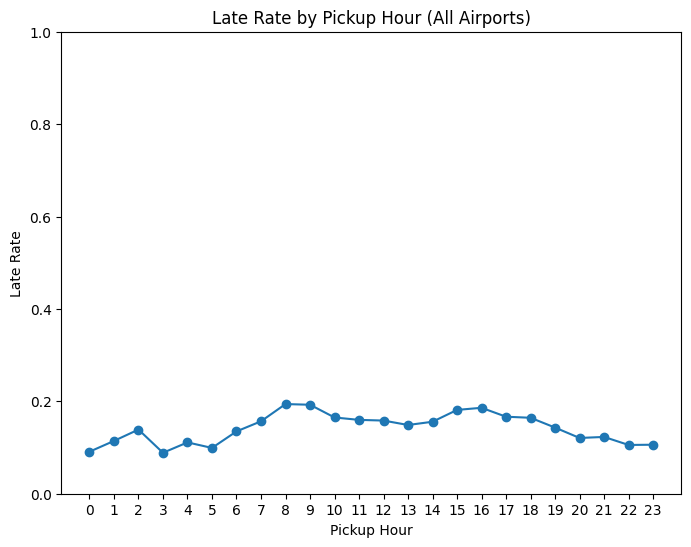

In [20]:
# Late Rate by Hour
late_by_hour = (taxi.groupby("hour")["late"].mean().reset_index().rename(columns={"late": "late_rate"}))

# Plot
fig, ax = plt.subplots(figsize=(8, 6))
ax.plot(late_by_hour["hour"], late_by_hour["late_rate"], marker="o")
ax.set_title("Late Rate by Pickup Hour (All Airports)")
ax.set_xlabel("Pickup Hour")
ax.set_ylabel("Late Rate")
ax.set_xticks(range(0, 24))
ax.set_ylim(0, 1)
plt.show()

There are dont many significant swings in the data. However we can see that between 5-9am, rush hour traffic in morning, the late rate is increasing and reaching its peak, and then 1-5pm is when we see another rise in the late rate. 

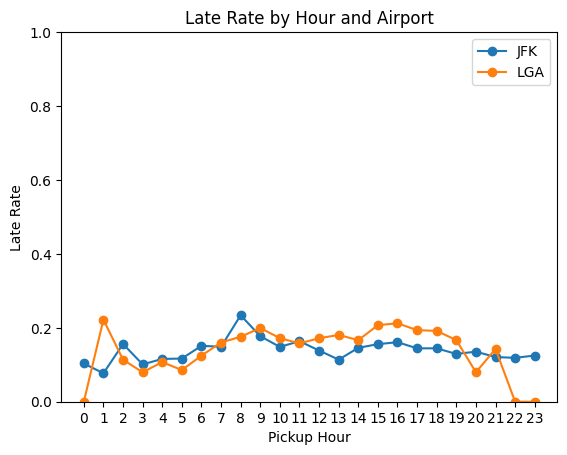

In [21]:
# Late Rate by Hour and Airport
late_by_airport_hour = (taxi.groupby(["airport", "hour"])["late"].mean().reset_index().rename(columns={"late": "late_rate"}))

for a in late_by_airport_hour["airport"].unique():
    subset = late_by_airport_hour[late_by_airport_hour["airport"] == a]
    plt.plot(subset["hour"], subset["late_rate"], marker="o", label=a)

# PLot
plt.title("Late Rate by Hour and Airport")
plt.xlabel("Pickup Hour")
plt.ylabel("Late Rate")
plt.xticks(range(0, 24))
plt.ylim(0, 1)
plt.legend()
plt.show()


### Late Rate by Day of Week

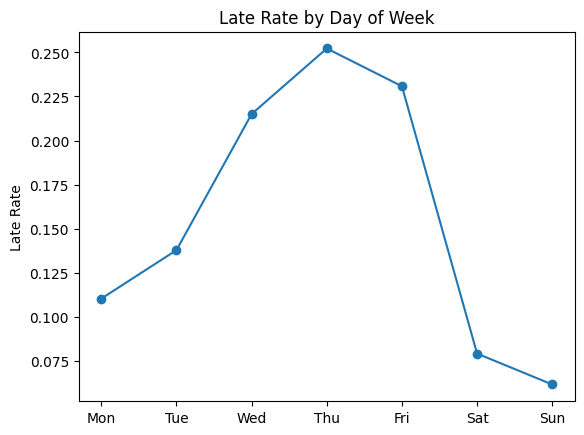

In [22]:
late_by_dow = (
    taxi.groupby("day_of_week")["late"]
    .mean()
    .reset_index()
)
plt.plot(late_by_dow["day_of_week"], late_by_dow["late"], marker="o")
plt.xticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.title("Late Rate by Day of Week")
plt.ylabel("Late Rate")
plt.show()


- Higher late rate during weekdays, with Wed-Fri being the highest.
- A massive drop during the weekends with saturday and sunday being the lowest late rate. 
- Days that have higher trip duration also show higher late rate and risk of being late, which makes sense. 

### Late Rate by Day of Week and Airport

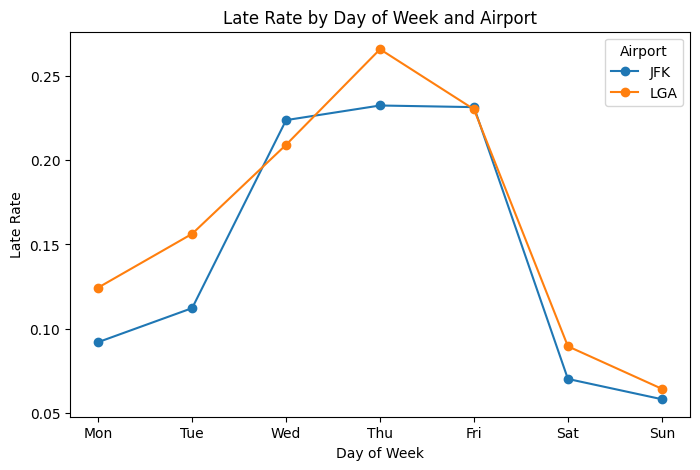

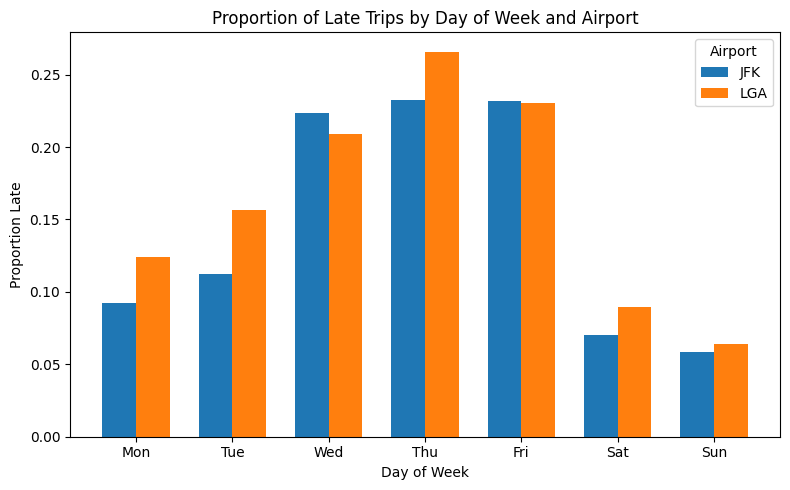

In [23]:
late_by_dow_airport = (
    taxi.groupby(["day_of_week", "airport"])["late"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 5))
for airport in late_by_dow_airport["airport"].unique():
    plt.plot(
        late_by_dow_airport[late_by_dow_airport["airport"] == airport]["day_of_week"],
        late_by_dow_airport[late_by_dow_airport["airport"] == airport]["late"],
        marker="o",
        label=airport
    )
plt.xticks(range(7), ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.title("Late Rate by Day of Week and Airport")
plt.ylabel("Late Rate")
plt.xlabel("Day of Week")
plt.legend(title="Airport")
plt.show()


# Percentage late by day of week, grouped bar by airport
late_by_dow_airport = (
    taxi.groupby(["day_of_week", "airport"])["late"]
    .mean()
    .reset_index()
)

plt.figure(figsize=(8, 5))
width = 0.35
airports = late_by_dow_airport["airport"].unique()
days = list(range(7))
x = np.arange(len(days))

for i, airport in enumerate(airports):
    y = late_by_dow_airport[late_by_dow_airport["airport"] == airport].set_index("day_of_week")["late"].reindex(days, fill_value=0).values
    plt.bar(x + i*width, y, width=width, label=airport)

plt.xticks(x + width/2, ["Mon","Tue","Wed","Thu","Fri","Sat","Sun"])
plt.title("Proportion of Late Trips by Day of Week and Airport")
plt.ylabel("Proportion Late")
plt.xlabel("Day of Week")
plt.legend(title="Airport")
plt.tight_layout()
plt.show()



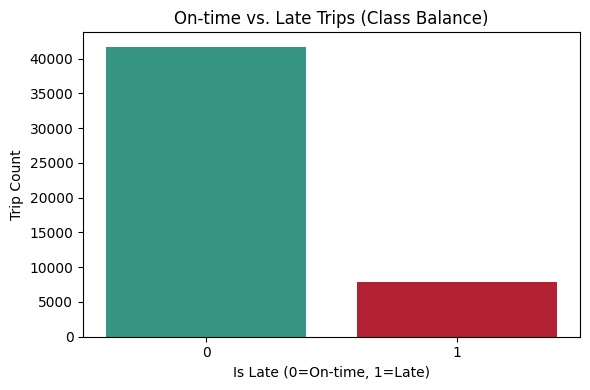

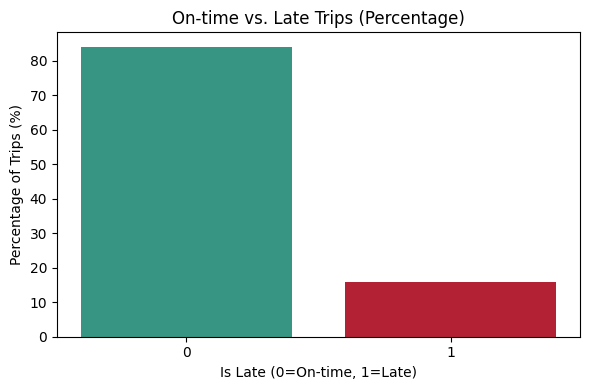

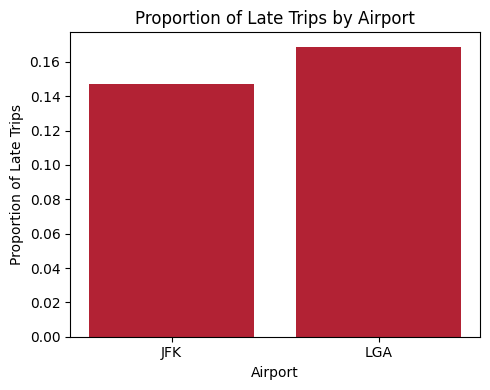

In [24]:
# Bar chart of late vs on-time trips
late_counts = taxi['late'].value_counts().sort_index()  # 0 first, then 1
plt.figure(figsize=(6,4))
plt.bar(late_counts.index.astype(str), late_counts.values, color=['#379683', '#b22234'])
plt.xlabel("Is Late (0=On-time, 1=Late)")
plt.ylabel("Trip Count")
plt.title("On-time vs. Late Trips (Class Balance)")
plt.tight_layout()
plt.show()

# Percentage bar (optional for showing imbalance clearly)
late_percent = late_counts / late_counts.sum() * 100
plt.figure(figsize=(6,4))
plt.bar(late_percent.index.astype(str), late_percent.values, color=['#379683', '#b22234'])
plt.xlabel("Is Late (0=On-time, 1=Late)")
plt.ylabel("Percentage of Trips (%)")
plt.title("On-time vs. Late Trips (Percentage)")
plt.tight_layout()
plt.show()

# Bar chart of % late by airport
late_by_airport = taxi.groupby('airport')['late'].mean().reset_index()
plt.figure(figsize=(5,4))
plt.bar(late_by_airport['airport'], late_by_airport['late'], color='#b22234')
plt.xlabel("Airport")
plt.ylabel("Proportion of Late Trips")
plt.title("Proportion of Late Trips by Airport")
plt.tight_layout()
plt.show()


### Zone EDA

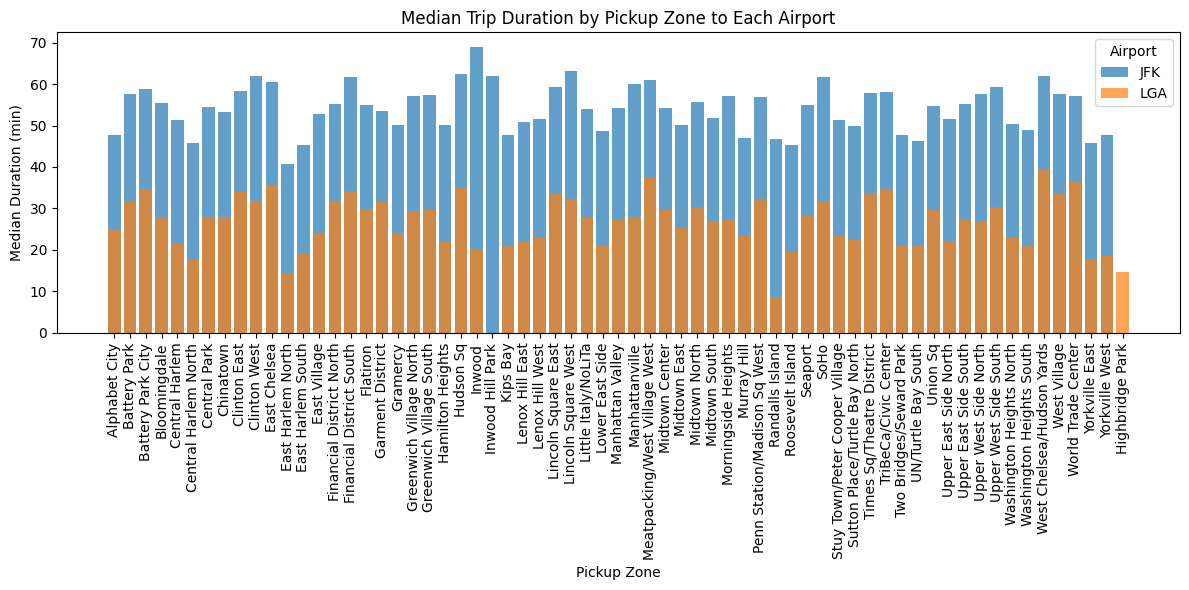

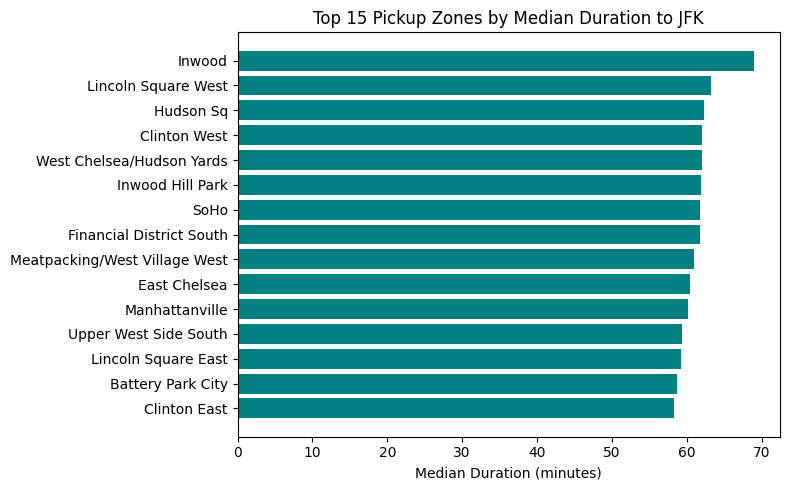

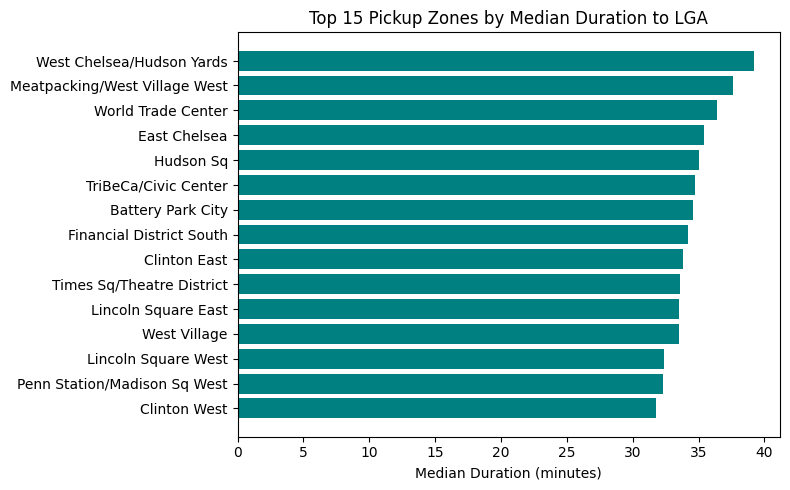

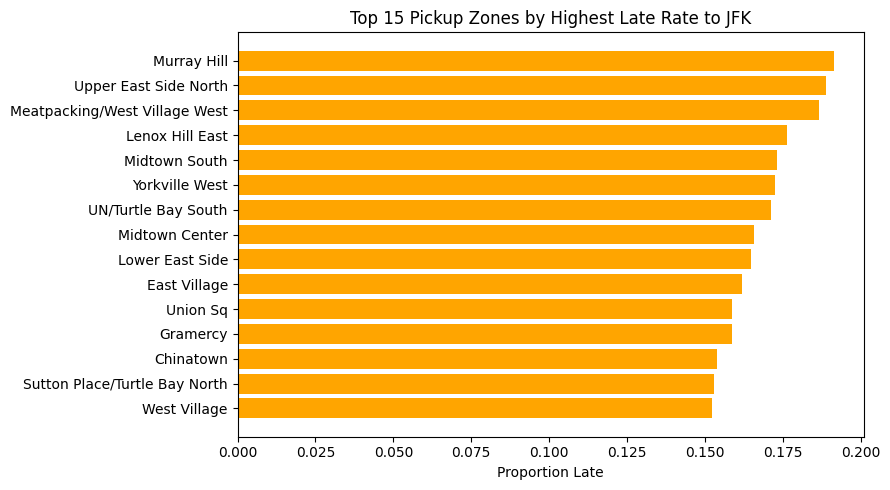

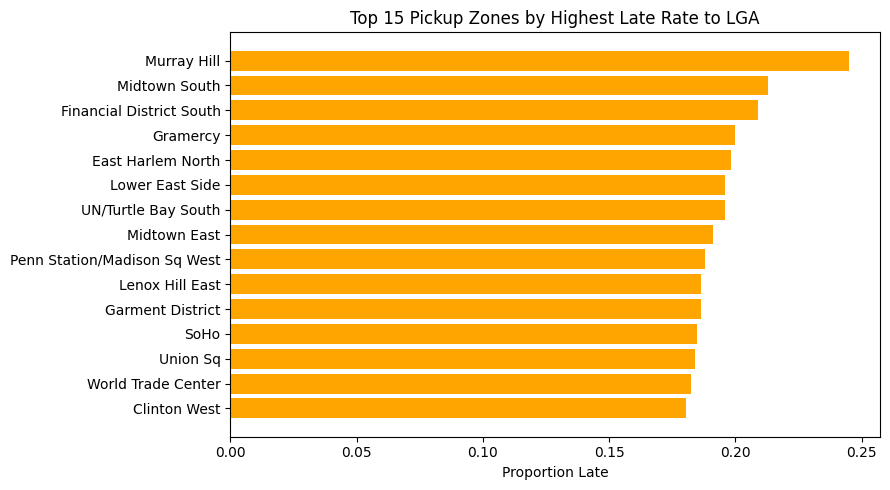

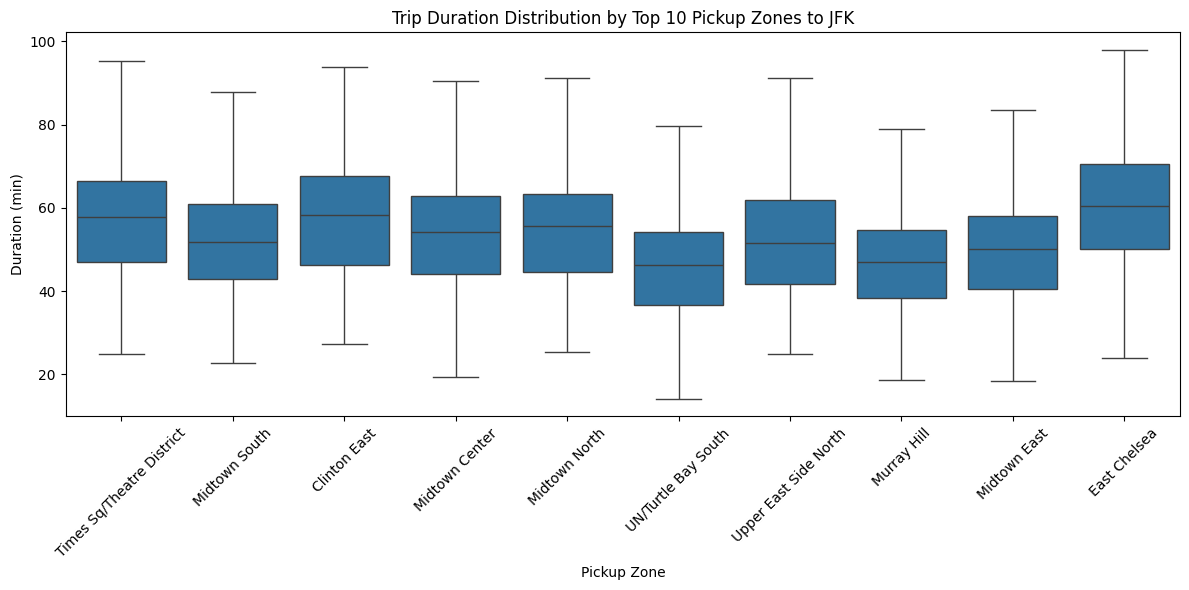

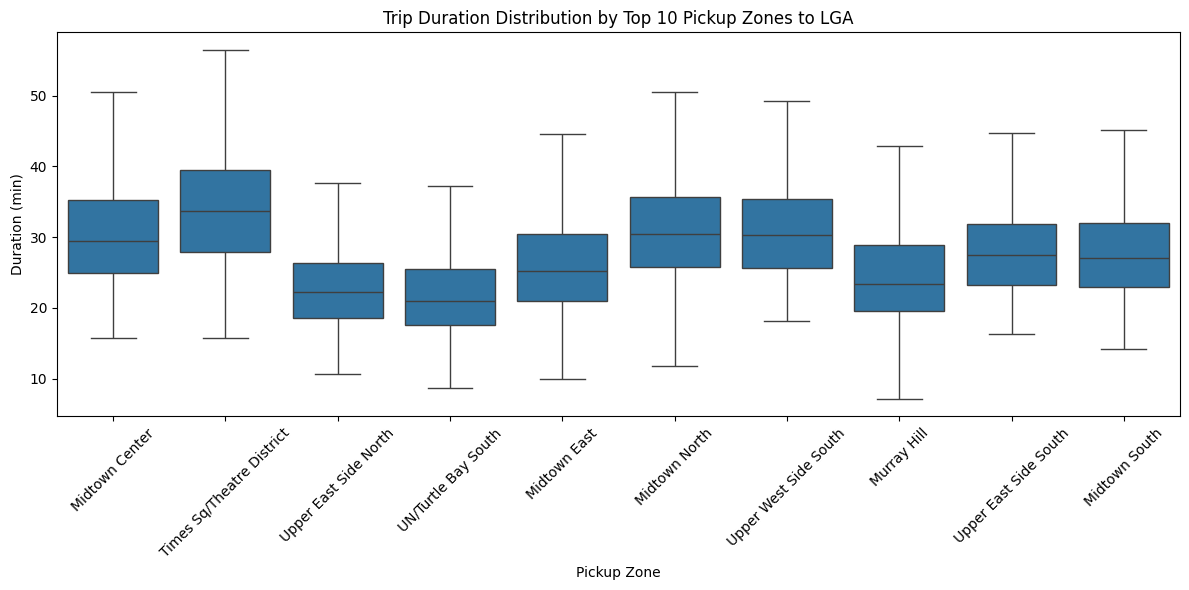

,pickup_zone,airport,n_trips,median_duration,late_rate
97,Times Sq/Theatre District,LGA,3381,33.630,0.154392
96,Times Sq/Theatre District,JFK,2540,57.800,0.143701
71,Midtown Center,LGA,2532,29.525,0.177725
75,Midtown North,LGA,1607,30.420,0.165526
73,Midtown East,LGA,1601,25.180,0.191131
70,Midtown Center,JFK,1417,54.130,0.165843
81,Murray Hill,LGA,1098,23.385,0.244991
74,Midtown North,JFK,1038,55.600,0.141618
77,Midtown South,LGA,1020,26.990,0.212745
72,Midtown East,JFK,962,50.220,0.151767


In [25]:
# Duration by Pickup Zone 
plt.figure(figsize=(12, 6))
duration_by_zone_airport = (taxi.groupby(['pickup_zone', 'airport'])['duration_min'].median().reset_index())

# Plot
for airport in duration_by_zone_airport['airport'].unique():
    data = duration_by_zone_airport[duration_by_zone_airport['airport'] == airport]
    plt.bar(data['pickup_zone'], data['duration_min'], label=airport, alpha=0.7)
plt.xlabel('Pickup Zone')
plt.ylabel('Median Duration (min)')
plt.title('Median Trip Duration by Pickup Zone to Each Airport')
plt.legend(title="Airport")
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

#  Top Pickup Zones by Median Duration (to JFK and LGA)
for airport in ['JFK', 'LGA']:
    top_durations = duration_by_zone_airport[duration_by_zone_airport['airport']==airport]
    top_durations = top_durations.sort_values('duration_min', ascending=False).head(15)
    plt.figure(figsize=(8, 5))
    plt.barh(top_durations['pickup_zone'], top_durations['duration_min'], color='teal')
    plt.xlabel('Median Duration (minutes)')
    plt.title(f'Top 15 Pickup Zones by Median Duration to {airport}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Late Rate by Pickup Zone to each airport
late_by_zone_airport = (taxi.groupby(['pickup_zone', 'airport'])['late'].mean().reset_index())
for airport in late_by_zone_airport['airport'].unique():
    zone_late = late_by_zone_airport[late_by_zone_airport['airport']==airport]
    top_late = zone_late.sort_values('late', ascending=False).head(15)
    plt.figure(figsize=(9, 5))
    plt.barh(top_late['pickup_zone'], top_late['late'], color='orange')
    plt.xlabel('Proportion Late')
    plt.title(f'Top 15 Pickup Zones by Highest Late Rate to {airport}')
    plt.gca().invert_yaxis()
    plt.tight_layout()
    plt.show()

# Duration Distribution by Pickup Zone to JFK and LGA
import seaborn as sns

for airport in ['JFK', 'LGA']:
    zone_counts = taxi[taxi['airport']==airport]['pickup_zone'].value_counts()
    top_zones = zone_counts.head(10).index.tolist()
    plt.figure(figsize=(12, 6))
    sns.boxplot(
        x='pickup_zone', y='duration_min',
        data=taxi[(taxi['airport']==airport) & (taxi['pickup_zone'].isin(top_zones))],
        showfliers=False
    )
    plt.title(f'Trip Duration Distribution by Top 10 Pickup Zones to {airport}')
    plt.xlabel('Pickup Zone')
    plt.ylabel('Duration (min)')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

#  Zone EDA Summary Table 
zone_summary = taxi.groupby(['pickup_zone', 'airport']).agg(
    n_trips = ('duration_min', 'count'),
    median_duration = ('duration_min', 'median'),
    late_rate = ('late', 'mean')
).reset_index()
display(zone_summary.sort_values('n_trips', ascending=False).head(15))

# Modeling

### Keep Columns only used for modeling

In [26]:
# Feature Columns for Regression
feature_cols_reg = ["pickup_zone", "airport", "hour", "day_of_week", "trip_distance", "payment_type"]

# Feature Columns for Classification
feature_cols_cls = ["pickup_zone", "airport", "hour", "day_of_week", "trip_distance", "payment_type"]

We are not using features like median_duration, fare_amount, tolls_amount, improvement_surcharge, and total_amount because they are either direct functions of trip duration or only known after the trip is completed. If we let the model see those features, it would be technically cheating by using post trip info that would not be available when a rider first gets in the cab, so we restrict the model to only pre trip features like pickup zone, airport, hour, day of week, distance, and payment type.

### Train/Test Split and Set Targets

In [27]:
from sklearn.model_selection import train_test_split

# Sort by pickup datetime
taxi = taxi.sort_values("tpep_pickup_datetime")

# Split into train/test
split_idx = int(0.8 * len(taxi))
train = taxi.iloc[:split_idx].copy()
test = taxi.iloc[split_idx:].copy()

# Feature Columns for Regression
X_train_reg = train[feature_cols_reg]
X_test_reg  = test[feature_cols_reg]
y_reg_train = train["duration_min"]
y_reg_test  = test["duration_min"]

# Feature Columns for Classification
X_train_cls = train[feature_cols_cls]
X_test_cls  = test[feature_cols_cls]
y_cls_train = train["late"]
y_cls_test  = test["late"]


In [28]:
print(len(train))
print(len(test))

39680
9921


### Baseline Model: Regression

In [29]:
from sklearn.metrics import mean_absolute_error, mean_squared_error
import numpy as np

# Baseline: predict the same value (training median) for every test trip
train_median = y_reg_train.median()

y_reg_pred_baseline = np.full_like(y_reg_test, fill_value=train_median, dtype=float)

mae_baseline = mean_absolute_error(y_reg_test, y_reg_pred_baseline)
mse_baseline = mean_squared_error(y_reg_test, y_reg_pred_baseline)
rmse_baseline = np.sqrt(mse_baseline)

print("Baseline (train median) MAE :", mae_baseline)
print("Baseline (train median) RMSE:", rmse_baseline)


Baseline (train median) MAE : 13.062379800423344
Baseline (train median) RMSE: 16.31660814602682


### Interpretation

- MAE is **13.06 min**, which means that on average, our median baseline is off by about **13 minutes** from the **actual trip duration.**

- **RMSE** is **16.32 min**. Bigger errors are penalized more, so that is why RMSE is slightly larger. 

- Typical trip durations to JFK based on our EDA is about 40–60 minutes and to LGA is about 25–35 minutes. A 6-minute MAE is roughly 10–15% error for a 40–50 minute trip. This is actually a pretty strong baseline, because it already uses detailed grouping of zone, airport and hour. 

### Baseline Model: Classification

In [30]:
from sklearn.metrics import accuracy_score, f1_score

most_common = y_cls_train.mode()[0]
y_cls_pred_dummy = np.full_like(y_cls_test, fill_value=most_common)

print("Baseline accuracy:", accuracy_score(y_cls_test, y_cls_pred_dummy))
print("Baseline F1:", f1_score(y_cls_test, y_cls_pred_dummy))


Baseline accuracy: 0.8720895071061385
Baseline F1: 0.0


Accuracy of 87% means about 87% of trips are on-time in the test set.

### Encoding/Preprocessing

Before any of our model sees our data, we are taking the columns below and leaving the numerical columns as it and turning the categorical text/ID columns into dummy variables using one-hot encoding. Models can not directly work with IDs like JFK, or some categorical data, so we convert to dummy variables.

In [31]:
# from sklearn.impute import SimpleImputer
# from sklearn.preprocessing import OneHotEncoder
# from sklearn.compose import ColumnTransformer
# from sklearn.pipeline import Pipeline

# numeric_features = ["trip_distance", "hour", "day_of_week", "passenger_count"]
# categorical_features = ["pickup_zone", "airport", "payment_type"]

# numeric_transformer = Pipeline(steps=[
#     ("imputer", SimpleImputer(strategy="median")),   # fill NaNs
# ])

# categorical_transformer = Pipeline(steps=[
#     ("onehot", OneHotEncoder(handle_unknown="ignore")),
# ])

# preprocessor = ColumnTransformer(
#     transformers=[
#         ("num", numeric_transformer, numeric_features),
#         ("cat", categorical_transformer, categorical_features),
#     ]
# )


In [32]:
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.pipeline import Pipeline

numeric_features = ["trip_distance", "hour", "day_of_week"]
categorical_features = ["pickup_zone", "airport", "payment_type"]

preprocessor = ColumnTransformer(transformers=[
        ("num", "passthrough", numeric_features),
        ("cat", OneHotEncoder(handle_unknown="ignore"), categorical_features),
    ])

## Regression Models

### XGBoost Regression Model

In [43]:
from xgboost import XGBRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Create Model
xgb_reg = XGBRegressor(objective="reg:squarederror", random_state=42, n_jobs=-1)

# Create Pipeline
reg_pipe = Pipeline(steps=[
    ("pre", preprocessor),
    ("model", xgb_reg),])

# Create Hyperparameter Grid + Search
param_grid_reg = {
    "model__n_estimators": [100,200,400,500],    # Number of trees
    "model__max_depth": [3, 5, 7, 10],        # Depth of each tree
    "model__learning_rate": [0.1, 0.05, 0.01],  # Learning rate
    "model__subsample": [0.8, 1.0, 0.5],       # Fraction of samples used for each tree
}

# Grid Search
grid_reg = GridSearchCV(
    estimator=reg_pipe,                   # Whole pipeline
    param_grid=param_grid_reg,            # Hyperparameter grid
    cv=3,                                 # 3-fold cross validation
    scoring="neg_mean_absolute_error",    # Scoring metric
    n_jobs=-1,                            # Use all available CPU cores
    verbose=1,                            # Print progress
)

# Fit Model
grid_reg.fit(X_train_reg, y_reg_train)
print("Best params (regression):", grid_reg.best_params_)
print("Best CV MAE:", -grid_reg.best_score_)

# Rename for clarity
best_xgb_reg = grid_reg.best_estimator_

Fitting 3 folds for each of 144 candidates, totalling 432 fits
Best params (regression): {'model__learning_rate': 0.05, 'model__max_depth': 7, 'model__n_estimators': 400, 'model__subsample': 0.8}
Best CV MAE: 5.52327313587696


##### Evaluate the XGBoost Model

In [44]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Train predictions 
y_pred_train_reg = best_xgb_reg.predict(X_train_reg)
mae_train = mean_absolute_error(y_reg_train, y_pred_train_reg)
mse_train = mean_squared_error(y_reg_train, y_pred_train_reg)
rmse_train = np.sqrt(mse_train)
r2_train = r2_score(y_reg_train, y_pred_train_reg)

# Test predictions 
y_pred_test_reg = best_xgb_reg.predict(X_test_reg)
mae_test = mean_absolute_error(y_reg_test, y_pred_test_reg)
mse_test = mean_squared_error(y_reg_test, y_pred_test_reg)
rmse_test = np.sqrt(mse_test)
r2_test = r2_score(y_reg_test, y_pred_test_reg)

print("\nTuned XGBoost Regression — Train vs Test")
print(f"Train MAE : {mae_train: .3f}")
print(f"Test  MAE : {mae_test: .3f}")
print(f"Train RMSE: {rmse_train: .3f}")
print(f"Test  RMSE: {rmse_test: .3f}")
print(f"Train R²  : {r2_train: .3f}")
print(f"Test  R²  : {r2_test: .3f}")


Tuned XGBoost Regression — Train vs Test
Train MAE :  4.520
Test  MAE :  5.605
Train RMSE:  6.407
Test  RMSE:  7.659
Train R²  :  0.870
Test  R²  :  0.773


**MAE ≈ 5.6 minutes on test**
- On average, our XGBoost model is off by about 5-6 minutes from the true trip duration. 
- Baseline MAE was 13.1, so we cut the average error by more than HALF, roughly a 57% reduction. 

**RMSE ≈ 7.7 minutes on test**
- Because RMSE penalizes big mistakes more, it’s larger than MAE.
  - Baseline RMSE was 16.3 minutes, so we reduced the size of the big errors by about 8–9 mins, which is a big improvement on the worst case trips.


**R² ≈ 0.78 on test**
- The model explains about 78% of the variance in trip duration on unseen data. 

Overall, the tuned XGBoost model performs much better than the simple median baseline model. MAE improved from 13.1 to 5.6 and RMSE improved from 16.3 to 7.7. The train vs test performance is reasonably close, with train MAE 4.5 vs test 5.6 and train R² 0.87 vs test 0.78. These results suggest only slight overfitting and good generalization to new trips.

#### Visualize the XGBoost Learning Curve

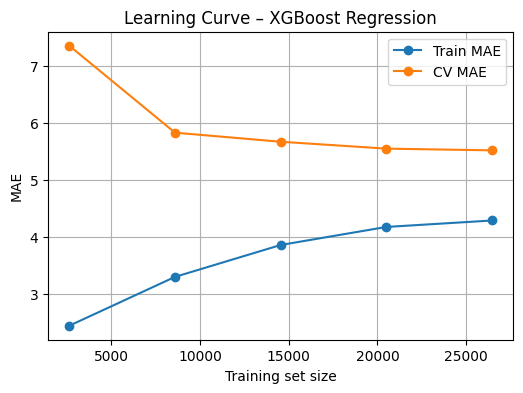

In [46]:
from sklearn.model_selection import learning_curve
import numpy as np
import matplotlib.pyplot as plt

train_sizes, train_scores, val_scores = learning_curve(
    best_xgb_reg,
    X_train_reg,
    y_reg_train,
    train_sizes=np.linspace(0.1, 1.0, 5),
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
)

train_mae = -train_scores.mean(axis=1)
val_mae   = -val_scores.mean(axis=1)

# plot
plt.figure(figsize=(6,4))
plt.plot(train_sizes, train_mae, marker="o", label="Train MAE")
plt.plot(train_sizes, val_mae, marker="o", label="CV MAE")
plt.xlabel("Training set size")
plt.ylabel("MAE")
plt.title("Learning Curve – XGBoost Regression")
plt.legend()
plt.grid(True)
plt.show()

As we increase the training set size, the training MAE rises and the cross-validated MAE falls, and the two curves converge around 5–6 minutes. This means XGBoost benefits from more data and generalizes better as we feed it more trips. By the largest training size, the gap between train and validation error is modest, suggesting only mild overfitting and good generalization. The validation MAE also levels off around 5.5 minutes, close to our held out test MAE, indicating that we are near the performance ceiling for this feature set.

#### XGBoost Errors and Residuals

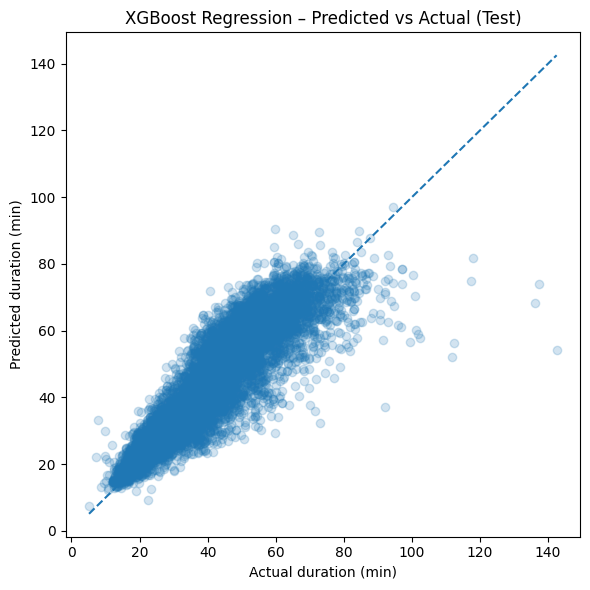

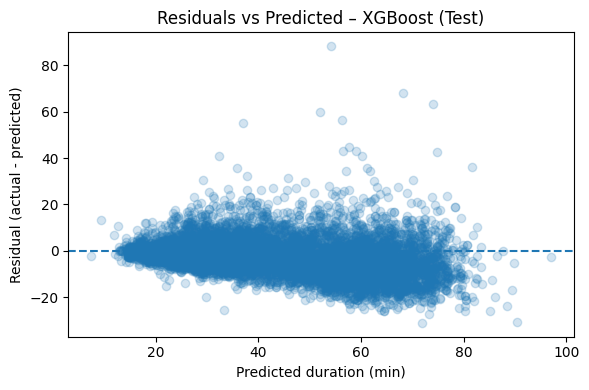

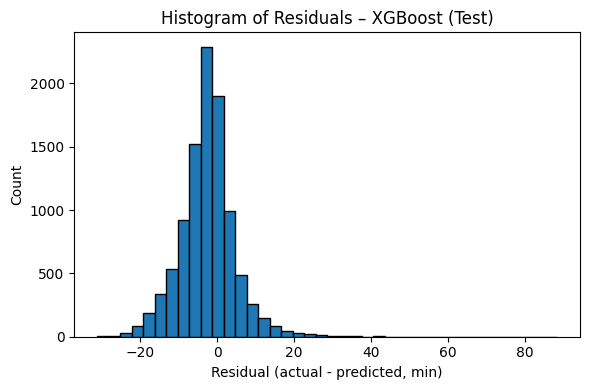

In [47]:
import numpy as np
import matplotlib.pyplot as plt

# Predictions on test set (pipeline applies encoding internally)
y_pred_test_reg = best_xgb_reg.predict(X_test_reg)

# Residuals: actual - predicted
residuals = y_reg_test - y_pred_test_reg
abs_errors = np.abs(residuals)

# Predicted vs Actual
plt.figure(figsize=(6, 6))
plt.scatter(y_reg_test, y_pred_test_reg, alpha=0.2)
plt.plot([y_reg_test.min(), y_reg_test.max()],
         [y_reg_test.min(), y_reg_test.max()],
         linestyle="--")
plt.xlabel("Actual duration (min)")
plt.ylabel("Predicted duration (min)")
plt.title("XGBoost Regression – Predicted vs Actual (Test)")
plt.tight_layout()
plt.show()

# Residuals vs Predicted
plt.figure(figsize=(6, 4))
plt.scatter(y_pred_test_reg, residuals, alpha=0.2)
plt.axhline(0, linestyle="--")
plt.xlabel("Predicted duration (min)")
plt.ylabel("Residual (actual - predicted)")
plt.title("Residuals vs Predicted – XGBoost (Test)")
plt.tight_layout()
plt.show()

# Residual Distribution
plt.figure(figsize=(6, 4))
plt.hist(residuals, bins=40, edgecolor="k")
plt.xlabel("Residual (actual - predicted, min)")
plt.ylabel("Count")
plt.title("Histogram of Residuals – XGBoost (Test)")
plt.tight_layout()
plt.show()

#### **Predicted vs Actual** 

- Points tightly clustered around the diagonal, indicating predictions are close to reality.

- The cloud is long and narrow and not a big blob, which means that most of the variation in actual duration is being captured, which matches our R² of 0.78.

- At small durations (10–30 min) the points are very close to the line, indicating the model is very accurate for shorter trips (LGA trips).

- For longer trips, 60–90+ min and mostly JFK, there is more spread around the line, which matches the slightly larger errors we’d expect on longer and more traffic heavy routes.

#### **Residuals vs Predicted** 

- Most residuals are between about −15 and +15 minutes, consistent with a test RMSE around 7–8 minutes.

- The cloud is centered near 0 for most predicted durations, indicating the model is roughly unbiased overall. 

- For higher predicted durations (60–80 min), we see more negative residuals, meaning the model sometimes over predicts long trips or occasionally under predicts very extreme traffic.

#### **Histrogram of Residuals** 

- Strong peak around 0 minutes, with most residuals in roughly -10 to +10 min.

- A long right tail is telling us that a small number of trips have residuals way above 20, 40, even 100 minutes. These those are the crazy traffic / crashes / weird outlier trips.

- Left tail exists but is shorter than the right tail, meaning the model has fewer extreme over predictions than under predictions.

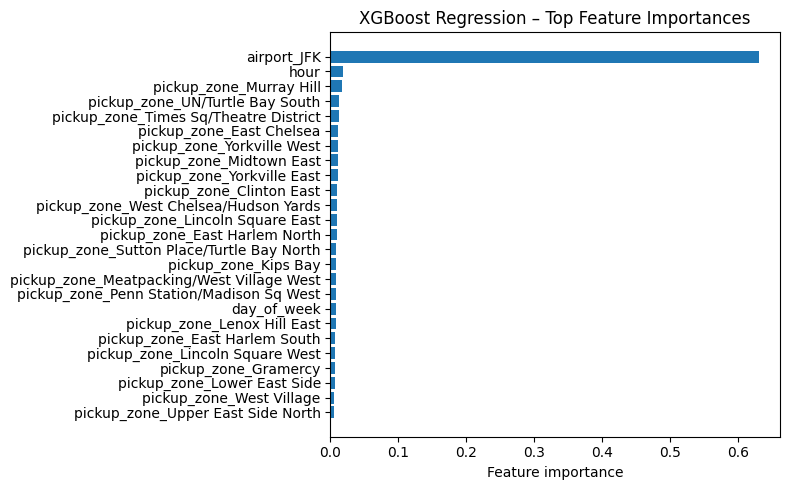

In [48]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature names from preprocessor
ohe = best_xgb_reg.named_steps["pre"].named_transformers_["cat"]
cat_feature_names = ohe.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

# Importances from XGB model
importances = best_xgb_reg.named_steps["model"].feature_importances_

k = 25
idx_sorted = np.argsort(importances)[::-1][:k]
top_feats = feature_names[idx_sorted]
top_imps  = importances[idx_sorted]

plt.figure(figsize=(8, 5))
plt.barh(range(len(top_feats)), top_imps)
plt.yticks(range(len(top_feats)), top_feats)
plt.gca().invert_yaxis()
plt.xlabel("Feature importance")
plt.title("XGBoost Regression – Top Feature Importances")
plt.tight_layout()
plt.show()

The most important feature by far is whether the trip is going to JFK, which makes sense because JFK trips are much longer and more variable than LGA trips. Hour of day and pickup zone then fine tune the estimate within each airport.

### AdaBoostRegressor Model

In [50]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.tree import DecisionTreeRegressor

# Create AdaBoostRegressor Model (base_estimator param is deprecated in >=0.24, use estimator instead)
ada_reg = AdaBoostRegressor(
    estimator=DecisionTreeRegressor(max_depth=3),  # basic weak learner, tunable
    random_state=42
)

# Create Pipeline
ada_reg_pipe = Pipeline([
    ("pre", preprocessor),          
    ("model", ada_reg)
])

# Create Expanded Hyperparameter Grid for AdaBoost
param_grid_ada = {
    "model__n_estimators": [50, 100, 200],                      # more estimators
    "model__learning_rate": [1.0, 0.5, 0.1, 0.05],                   # common rates
    "model__estimator__max_depth": [1, 2, 3],                     # weak learner complexity
    "model__estimator__min_samples_split": [2, 5, 10],               # min samples to split node
    "model__estimator__min_samples_leaf": [1, 2, 4]                  # min samples at leaf
}

# Grid Search for AdaBoost Regressor
grid_ada = GridSearchCV(
    estimator=ada_reg_pipe,
    param_grid=param_grid_ada,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1,
)

# Fit Model
grid_ada.fit(X_train_reg, y_reg_train)
print("Best params (AdaBoost regression):", grid_ada.best_params_)
print("Best CV MAE:", -grid_ada.best_score_)

# Rename for clarity
best_ada_reg = grid_ada.best_estimator_

# Predictions
y_pred_ada_train = best_ada_reg.predict(X_train_reg)
y_pred_ada_test  = best_ada_reg.predict(X_test_reg)

# Metrics
mae_tr_ada, rmse_tr_ada, r2_tr_ada = reg_metrics(y_reg_train, y_pred_ada_train)
mae_te_ada, rmse_te_ada, r2_te_ada = reg_metrics(y_reg_test,  y_pred_ada_test)

print("AdaBoost Regression — Train vs Test")
print(f"Train MAE : {mae_tr_ada: .3f}")
print(f"Test  MAE : {mae_te_ada: .3f}")
print(f"Train RMSE: {rmse_tr_ada: .3f}")
print(f"Test  RMSE: {rmse_te_ada: .3f}")
print(f"Train R²  : {r2_tr_ada: .3f}")
print(f"Test  R²  : {r2_te_ada: .3f}")

Fitting 3 folds for each of 324 candidates, totalling 972 fits
Best params (AdaBoost regression): {'model__estimator__max_depth': 3, 'model__estimator__min_samples_leaf': 1, 'model__estimator__min_samples_split': 2, 'model__learning_rate': 0.05, 'model__n_estimators': 50}
Best CV MAE: 7.695857019549188
AdaBoost Regression — Train vs Test
Train MAE :  7.520
Test  MAE :  7.625
Train RMSE:  10.121
Test  RMSE:  10.005
Train R²  :  0.675
Test  R²  :  0.612


#### AdaBoost results and graphs

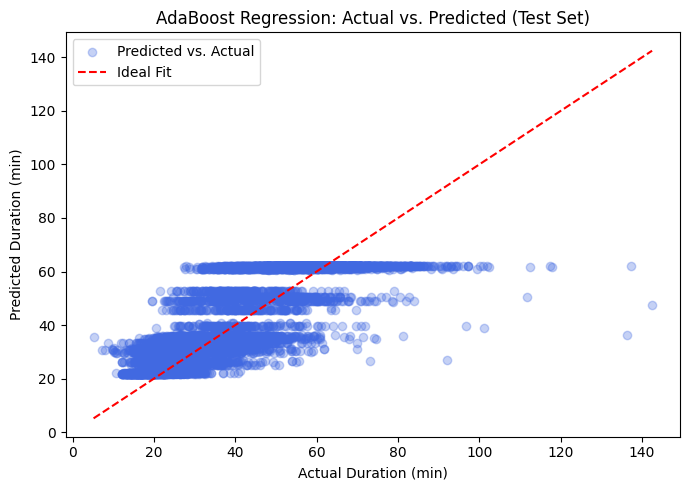

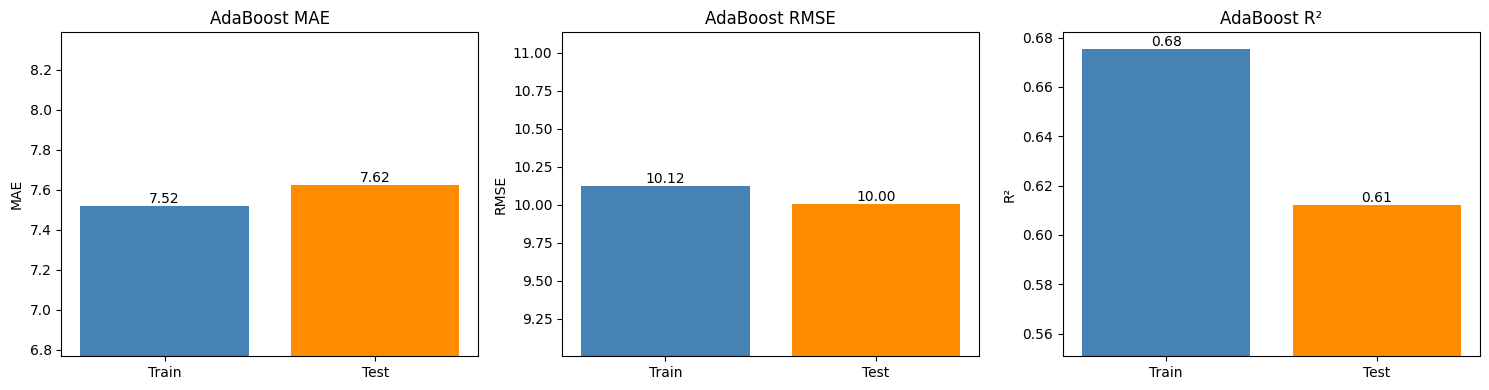

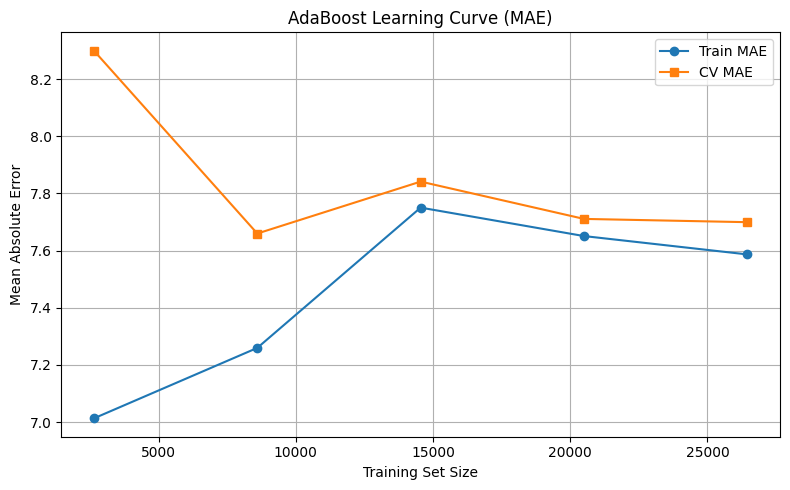

In [51]:
import matplotlib.pyplot as plt

# Plotting Actual vs Predicted for AdaBoost Regression (Test set)
plt.figure(figsize=(7,5))
plt.scatter(y_reg_test, y_pred_ada_test, alpha=0.3, label="Predicted vs. Actual", color='royalblue')
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Duration (min)')
plt.ylabel('Predicted Duration (min)')
plt.title('AdaBoost Regression: Actual vs. Predicted (Test Set)')
plt.legend()
plt.tight_layout()
plt.show()

# Bar chart summary of key metrics (Train vs Test) for AdaBoost
ada_metrics = {
    "MAE": [mae_tr_ada, mae_te_ada],
    "RMSE": [rmse_tr_ada, rmse_te_ada],
    "R²": [r2_tr_ada, r2_te_ada],
}
labels = ["Train", "Test"]

fig, axs = plt.subplots(1, 3, figsize=(15,4))
cols = list(ada_metrics.keys())
for i, metric in enumerate(cols):
    axs[i].bar(labels, ada_metrics[metric], color=['steelblue', 'darkorange'])
    axs[i].set_title(f"AdaBoost {metric}")
    axs[i].set_ylim(
        min(ada_metrics[metric]) * 0.9,
        max(ada_metrics[metric]) * (1.1 if metric != 'R²' else 1.01)
    )
    axs[i].set_ylabel(metric)
    for idx, val in enumerate(ada_metrics[metric]):
        axs[i].text(idx, val, f"{val:.2f}", ha="center", va="bottom", fontsize=10, color="black")
plt.tight_layout()
plt.show()

# Track learning curves (optionally)
from sklearn.model_selection import learning_curve

train_sizes, train_scores, val_scores = learning_curve(
    best_ada_reg, X_train_reg, y_reg_train, cv=3,
    scoring="neg_mean_absolute_error", train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)
train_mae = -train_scores.mean(axis=1)
val_mae = -val_scores.mean(axis=1)
plt.figure(figsize=(8,5))
plt.plot(train_sizes, train_mae, marker='o', label='Train MAE')
plt.plot(train_sizes, val_mae, marker='s', label='CV MAE')
plt.xlabel("Training Set Size")
plt.ylabel("Mean Absolute Error")
plt.title("AdaBoost Learning Curve (MAE)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


## Linear Regression Model

In [52]:
from sklearn.linear_model import LinearRegression
from sklearn.pipeline import Pipeline
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

# Linear Regression pipeline
lin_reg_pipe = Pipeline([
    ("pre", preprocessor),          
    ("model", LinearRegression())
])

lin_reg_pipe.fit(X_train_reg, y_reg_train)

# Predictions
y_pred_lin_train = lin_reg_pipe.predict(X_train_reg)
y_pred_lin_test  = lin_reg_pipe.predict(X_test_reg)

# Metrics
def reg_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

mae_tr_lin, rmse_tr_lin, r2_tr_lin = reg_metrics(y_reg_train, y_pred_lin_train)
mae_te_lin, rmse_te_lin, r2_te_lin = reg_metrics(y_reg_test,  y_pred_lin_test)

print("Linear Regression — Train vs Test")
print(f"Train MAE : {mae_tr_lin: .3f}")
print(f"Test  MAE : {mae_te_lin: .3f}")
print(f"Train RMSE: {rmse_tr_lin: .3f}")
print(f"Test  RMSE: {rmse_te_lin: .3f}")
print(f"Train R²  : {r2_tr_lin: .3f}")
print(f"Test  R²  : {r2_te_lin: .3f}")


Linear Regression — Train vs Test
Train MAE :  7.472
Test  MAE :  6.619
Train RMSE:  10.517
Test  RMSE:  9.086
Train R²  :  0.649
Test  R²  :  0.680


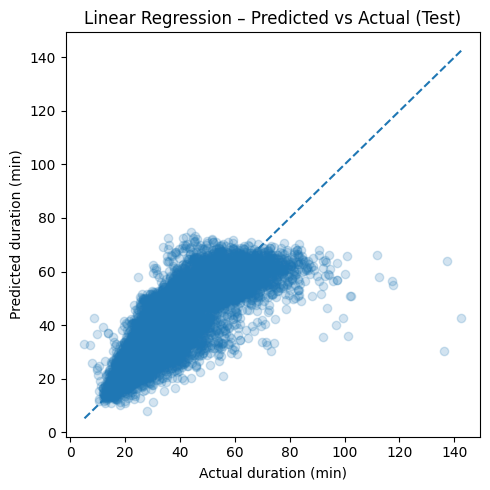

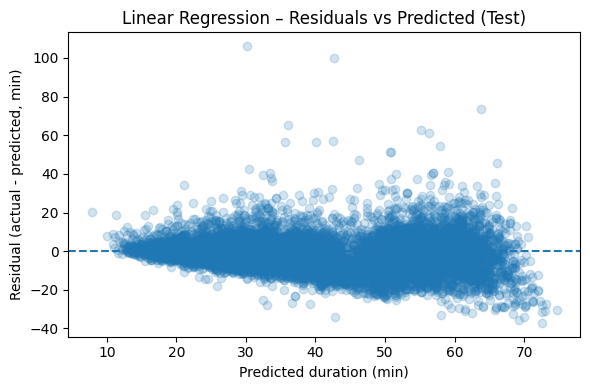

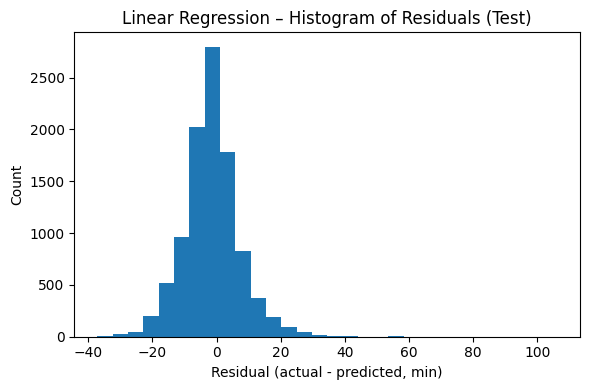

In [53]:
import matplotlib.pyplot as plt
import numpy as np

def plot_pred_vs_actual(y_true, y_pred, title):
    plt.figure(figsize=(5,5))
    plt.scatter(y_true, y_pred, alpha=0.2)
    max_val = max(y_true.max(), y_pred.max())
    min_val = min(y_true.min(), y_pred.min())
    plt.plot([min_val, max_val], [min_val, max_val], linestyle="--")
    plt.xlabel("Actual duration (min)")
    plt.ylabel("Predicted duration (min)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_residuals_vs_pred(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6,4))
    plt.scatter(y_pred, residuals, alpha=0.2)
    plt.axhline(0, linestyle="--")
    plt.xlabel("Predicted duration (min)")
    plt.ylabel("Residual (actual - predicted, min)")
    plt.title(title)
    plt.tight_layout()
    plt.show()

def plot_residual_hist(y_true, y_pred, title):
    residuals = y_true - y_pred
    plt.figure(figsize=(6,4))
    plt.hist(residuals, bins=30)
    plt.xlabel("Residual (actual - predicted, min)")
    plt.ylabel("Count")
    plt.title(title)
    plt.tight_layout()
    plt.show()


# Test-set visuals for Linear Regression
plot_pred_vs_actual(y_reg_test, y_pred_lin_test,
                    "Linear Regression – Predicted vs Actual (Test)")

plot_residuals_vs_pred(y_reg_test, y_pred_lin_test,
                       "Linear Regression – Residuals vs Predicted (Test)")

plot_residual_hist(y_reg_test, y_pred_lin_test,
                   "Linear Regression – Histogram of Residuals (Test)")



## Random Forest Regression Model

### Random Forest Grid

In [54]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
import numpy as np

def reg_metrics(y_true, y_pred):
    mae = mean_absolute_error(y_true, y_pred)
    mse = mean_squared_error(y_true, y_pred)
    rmse = np.sqrt(mse)
    r2 = r2_score(y_true, y_pred)
    return mae, rmse, r2

# Base RF model 
rf_reg = RandomForestRegressor(random_state=42, n_jobs=-1)

# Pipeline
rf_pipe = Pipeline([
    ("pre", preprocessor),   
    ("model", rf_reg)
])

# Set Grid Search Parameters
param_grid_rf = {
    "model__n_estimators": [100, 200, 400, 500],
    "model__max_depth": [None, 15, 25],
    "model__min_samples_leaf": [3, 5, 10],
    "model__max_features": ["sqrt", "log2"]
}

# Grid Search
grid_rf = GridSearchCV(
    estimator=rf_pipe,
    param_grid=param_grid_rf,
    cv=3,
    scoring="neg_mean_absolute_error",
    n_jobs=-1,
    verbose=1
)

grid_rf.fit(X_train_reg, y_reg_train)
print("Best RF params:", grid_rf.best_params_)
print("Best CV MAE:", -grid_rf.best_score_)

Fitting 3 folds for each of 72 candidates, totalling 216 fits
Best RF params: {'model__max_depth': None, 'model__max_features': 'sqrt', 'model__min_samples_leaf': 3, 'model__n_estimators': 500}
Best CV MAE: 5.840228725682052


In [55]:
best_rf_model = grid_rf.best_estimator_

y_pred_rf_train = best_rf_model.predict(X_train_reg)
y_pred_rf_test  = best_rf_model.predict(X_test_reg)

mae_tr_rf, rmse_tr_rf, r2_tr_rf = reg_metrics(y_reg_train, y_pred_rf_train)
mae_te_rf, rmse_te_rf, r2_te_rf = reg_metrics(y_reg_test,  y_pred_rf_test)

print("\nTuned Random Forest — Train vs Test")
print(f"Train MAE : {mae_tr_rf: .3f}")
print(f"Test  MAE : {mae_te_rf: .3f}")
print(f"Train RMSE: {rmse_tr_rf: .3f}")
print(f"Test  RMSE: {rmse_te_rf: .3f}")
print(f"Train R²  : {r2_tr_rf: .3f}")
print(f"Test  R²  : {r2_te_rf: .3f}")



Tuned Random Forest — Train vs Test
Train MAE :  4.739
Test  MAE :  5.607
Train RMSE:  6.835
Test  RMSE:  7.599
Train R²  :  0.852
Test  R²  :  0.776


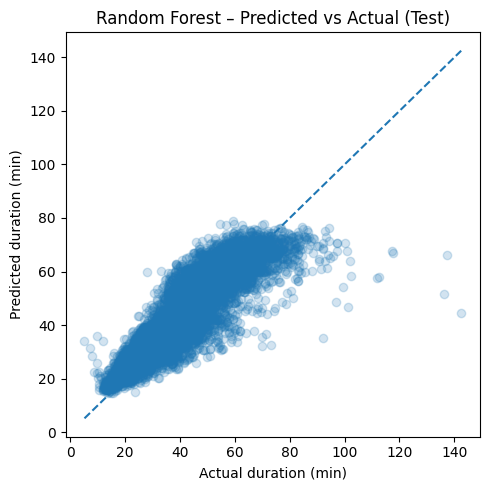

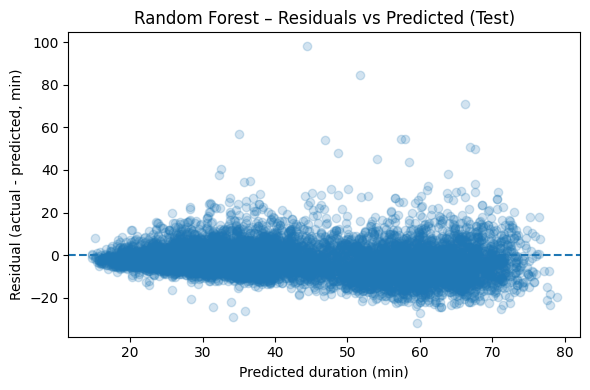

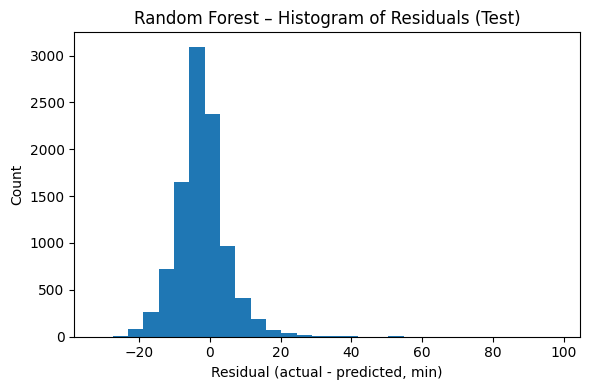

In [56]:
# Test-set visuals for Random Forest
plot_pred_vs_actual(y_reg_test, y_pred_rf_test, "Random Forest – Predicted vs Actual (Test)")
plot_residuals_vs_pred(y_reg_test, y_pred_rf_test, "Random Forest – Residuals vs Predicted (Test)")
plot_residual_hist(y_reg_test, y_pred_rf_test, "Random Forest – Histogram of Residuals (Test)")

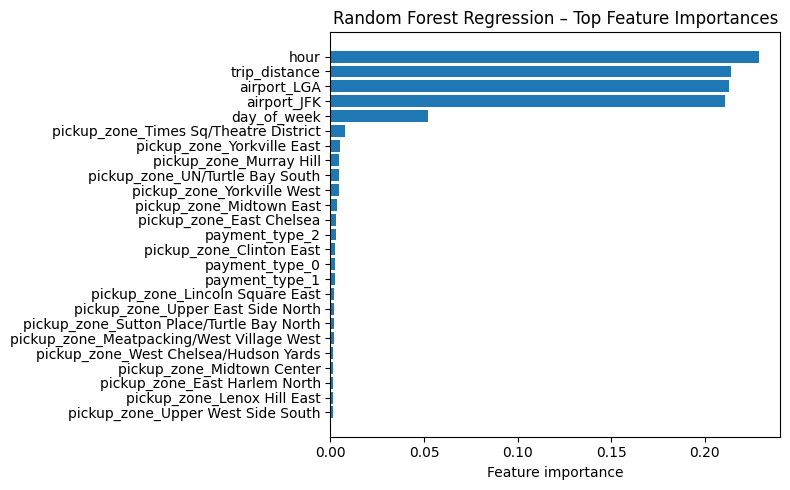

In [38]:
import numpy as np
import matplotlib.pyplot as plt

# Get feature names from preprocessor
ohee = best_rf_model.named_steps["pre"].named_transformers_["cat"]
cat_feature_names = ohee.get_feature_names_out(categorical_features)
feature_names = np.concatenate([numeric_features, cat_feature_names])

# Importances from XGB model
importances = best_rf_model.named_steps["model"].feature_importances_

k = 25
idx_sorted = np.argsort(importances)[::-1][:k]
top_feats = feature_names[idx_sorted]
top_imps  = importances[idx_sorted]

plt.figure(figsize=(8, 5))
plt.barh(range(len(top_feats)), top_imps)
plt.yticks(range(len(top_feats)), top_feats)
plt.gca().invert_yaxis()
plt.xlabel("Feature importance")
plt.title("Random Forest Regression – Top Feature Importances")
plt.tight_layout()
plt.show()

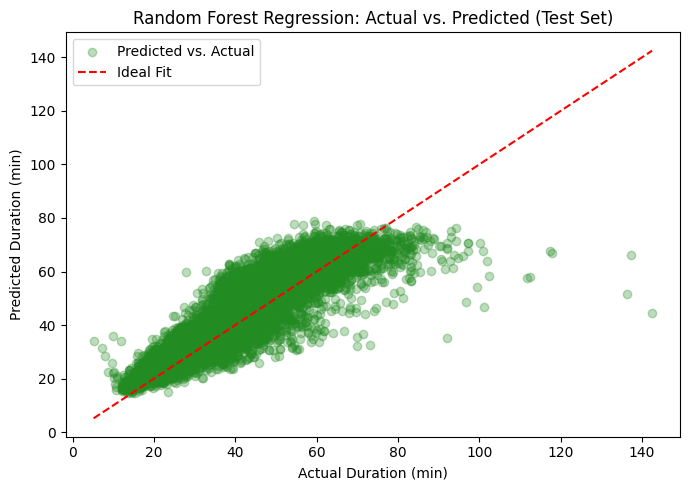

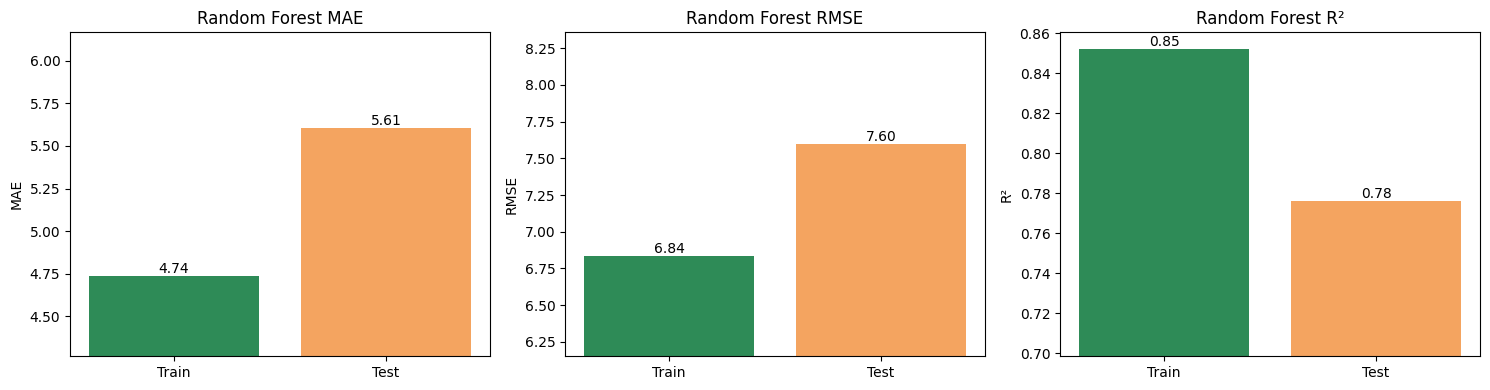

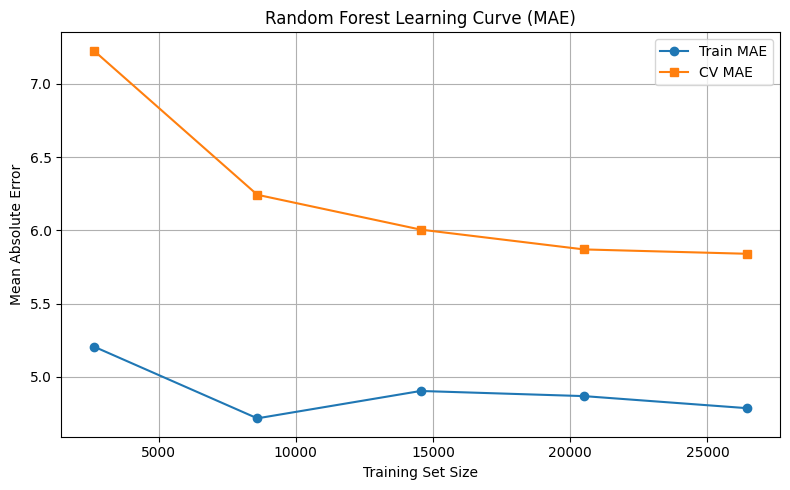

In [57]:
import matplotlib.pyplot as plt

# Plotting Actual vs Predicted for Random Forest Regression (Test set)
plt.figure(figsize=(7,5))
plt.scatter(y_reg_test, y_pred_rf_test, alpha=0.3, label="Predicted vs. Actual", color='forestgreen')
plt.plot([y_reg_test.min(), y_reg_test.max()], [y_reg_test.min(), y_reg_test.max()], 'r--', label='Ideal Fit')
plt.xlabel('Actual Duration (min)')
plt.ylabel('Predicted Duration (min)')
plt.title('Random Forest Regression: Actual vs. Predicted (Test Set)')
plt.legend()
plt.tight_layout()
plt.show()

# Bar chart summary of key metrics (Train vs Test) for Random Forest
rf_metrics = {
    "MAE": [mae_tr_rf, mae_te_rf],
    "RMSE": [rmse_tr_rf, rmse_te_rf],
    "R²": [r2_tr_rf, r2_te_rf],
}
labels = ["Train", "Test"]

fig, axs = plt.subplots(1, 3, figsize=(15,4))
cols = list(rf_metrics.keys())
for i, metric in enumerate(cols):
    axs[i].bar(labels, rf_metrics[metric], color=['seagreen', 'sandybrown'])
    axs[i].set_title(f"Random Forest {metric}")
    axs[i].set_ylim(
        min(rf_metrics[metric]) * 0.9,
        max(rf_metrics[metric]) * (1.1 if metric != 'R²' else 1.01)
    )
    axs[i].set_ylabel(metric)
    for idx, val in enumerate(rf_metrics[metric]):
        axs[i].text(idx, val, f"{val:.2f}", ha="center", va="bottom", fontsize=10, color="black")
plt.tight_layout()
plt.show()

# Track learning curves (optionally) for Random Forest
from sklearn.model_selection import learning_curve

train_sizes_rf, train_scores_rf, val_scores_rf = learning_curve(
    best_rf_model, X_train_reg, y_reg_train, cv=3,
    scoring="neg_mean_absolute_error", train_sizes=np.linspace(0.1, 1.0, 5),
    n_jobs=-1
)
train_mae_rf = -train_scores_rf.mean(axis=1)
val_mae_rf = -val_scores_rf.mean(axis=1)
plt.figure(figsize=(8,5))
plt.plot(train_sizes_rf, train_mae_rf, marker='o', label='Train MAE')
plt.plot(train_sizes_rf, val_mae_rf, marker='s', label='CV MAE')
plt.xlabel("Training Set Size")
plt.ylabel("Mean Absolute Error")
plt.title("Random Forest Learning Curve (MAE)")
plt.legend()
plt.grid()
plt.tight_layout()
plt.show()


In [47]:
import numpy as np

# Make a copy so we don't mess up the original
test_reg = test.copy()

# Add predictions for each regression model
test_reg["pred_lin"] = lin_reg_pipe.predict(X_test_reg)
test_reg["pred_rf"]  = best_rf_model.predict(X_test_reg)
test_reg["pred_xgb"] = best_xgb_reg.predict(X_test_reg) 

# Residuals (actual - predicted) and absolute error for each model
for name in ["lin", "rf", "xgb"]:
    test_reg[f"err_{name}"]     = test_reg["duration_min"] - test_reg[f"pred_{name}"]
    test_reg[f"abs_err_{name}"] = test_reg[f"err_{name}"].abs()

### All 3 Model Interpretations

We chose the tuned Random Forest as our final prediction model because it has the best test performance. It produced the lowest MAE (5.61 min) and lowest RMSE (7.60 min) along with the highest test R² (0.776) compared to XGBoost and Linear Regression. On unseen trips the Random Forest’s errors are slightly smaller and it explains a bit more variance in trip duration, so it generalizes best while still keeping train vs. test performance very close and limiting overfitting

### Predictions by Zone + Airport

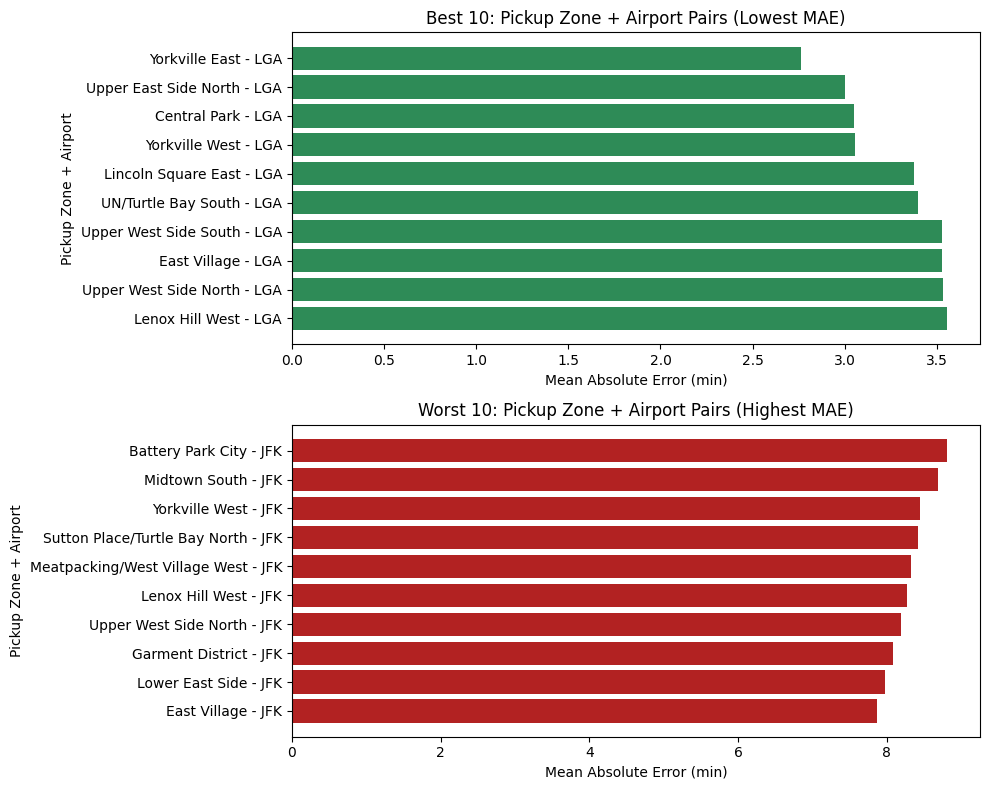

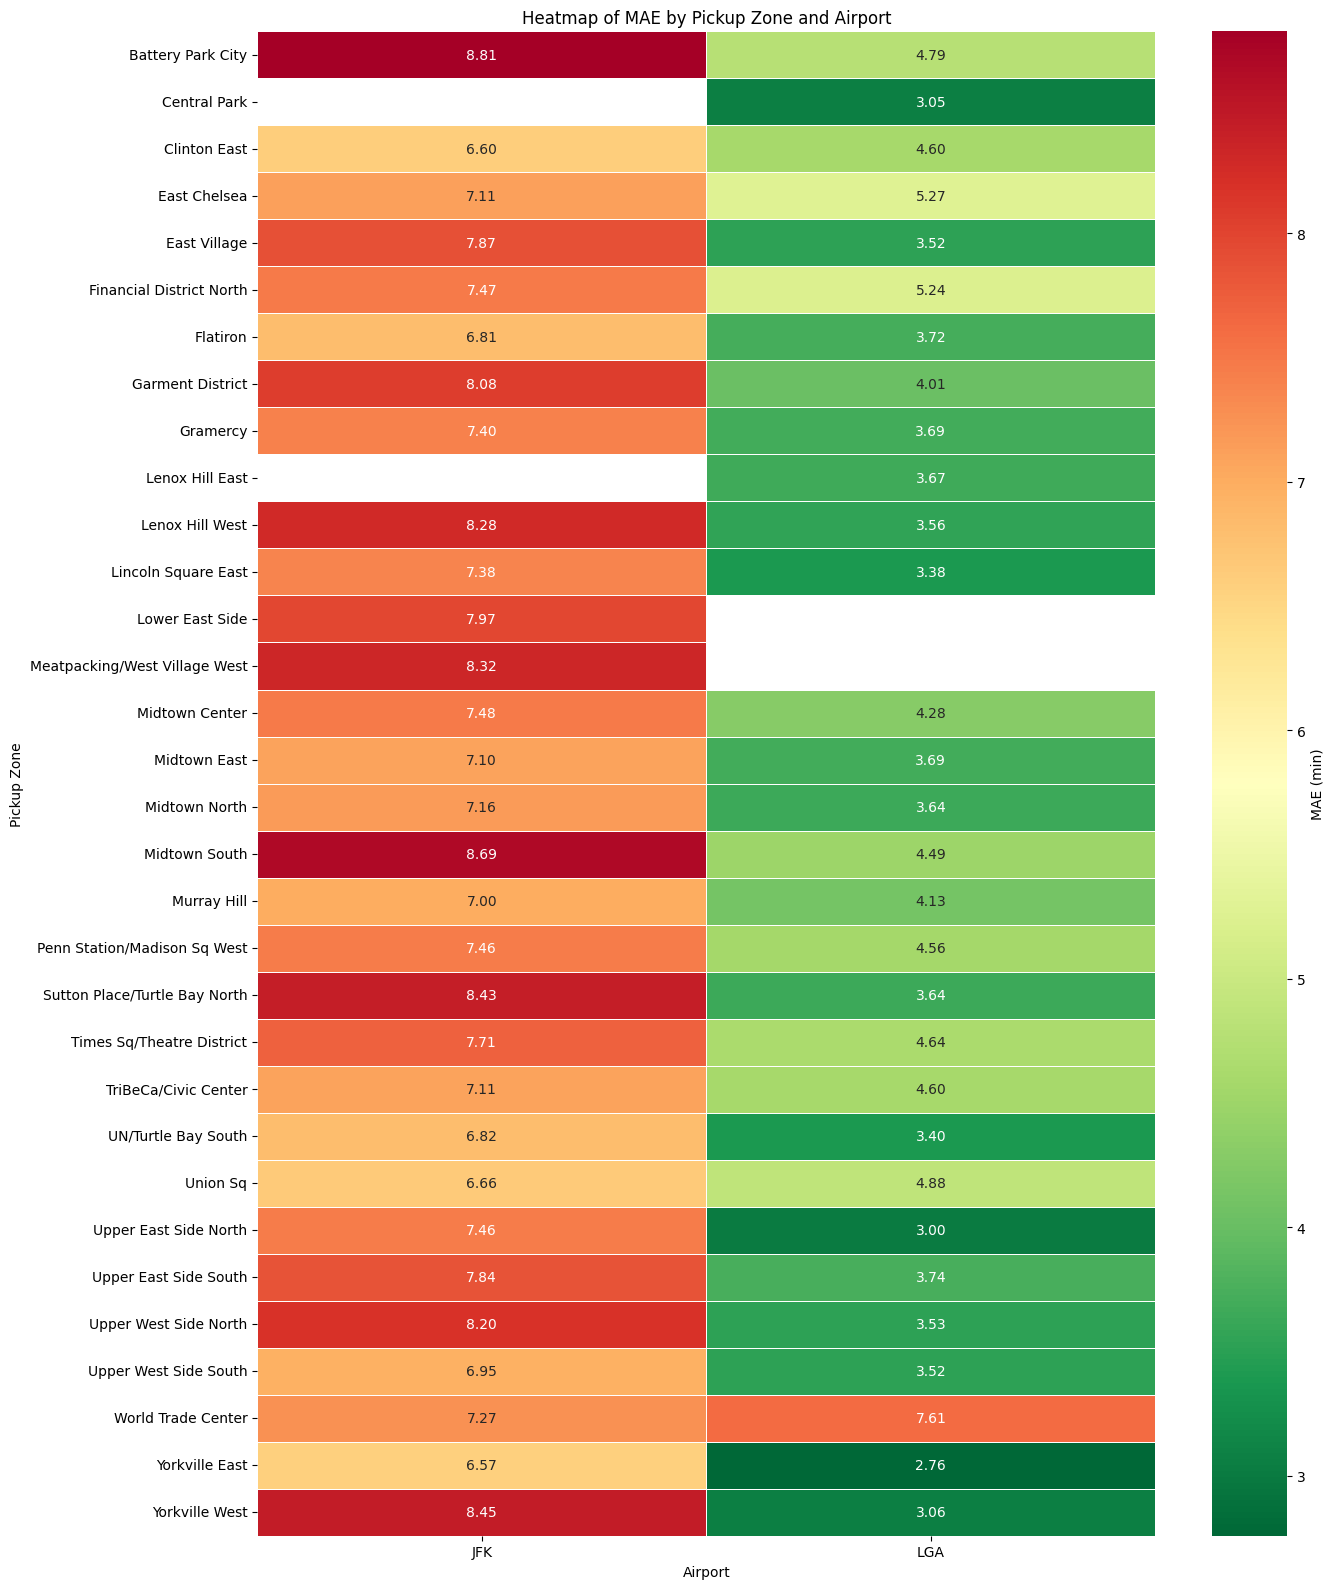

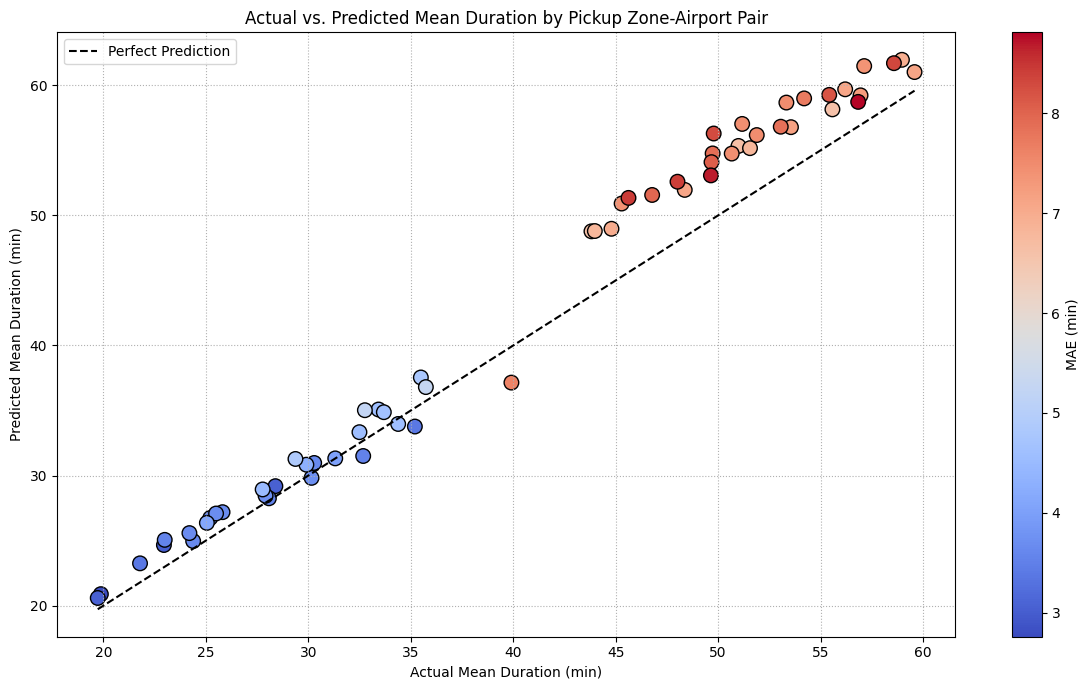

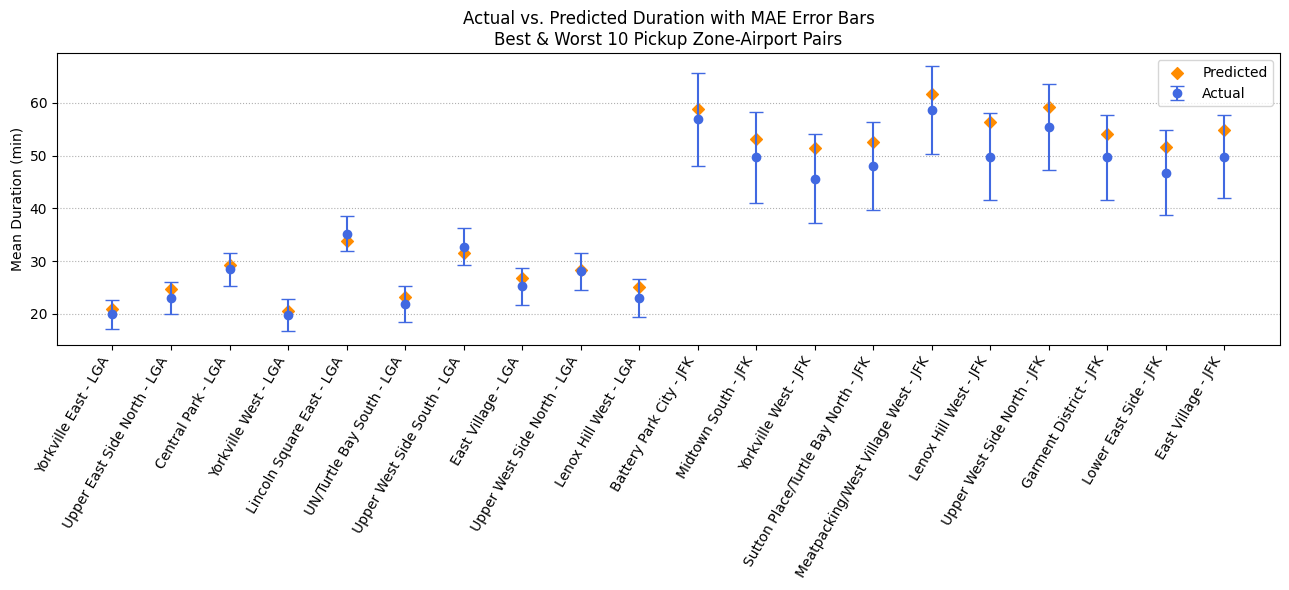

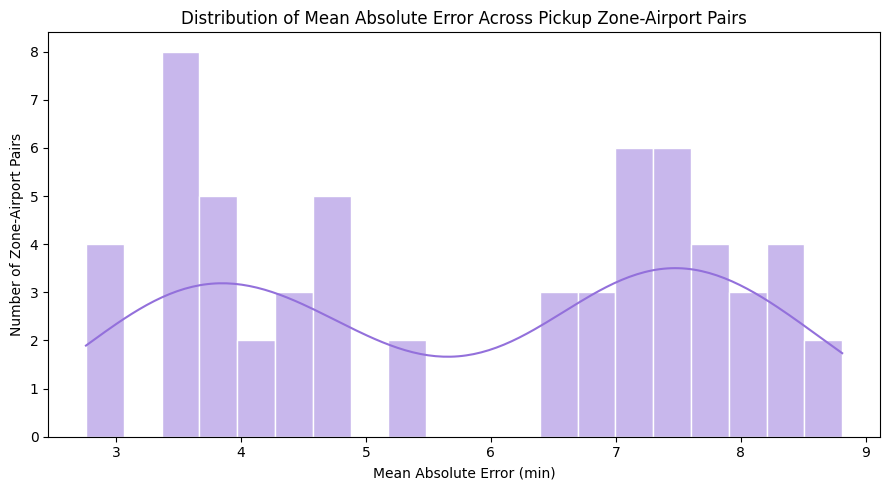

In [54]:
zone_airport_summary = (test_reg.groupby(["pickup_zone", "airport"]).agg(
    n_trips = ("duration_min", "size"),
    actual_mean = ("duration_min", "mean"),
    pred_rf_mean = ("pred_rf", "mean"),
    mae_rf = ("abs_err_rf", "mean")
    )
    .reset_index())


# Filter to zones with enough trips and sort by error or time
zone_airport_summary = (zone_airport_summary.query("n_trips >= 50").sort_values("mae_rf"))
zone_airport_summary.head()


# Show the 10 pickup zone + airport combos with the lowest and highest MAE (model error)

import matplotlib.pyplot as plt

# Best 10 (lowest error)
best10 = zone_airport_summary.nsmallest(10, "mae_rf")
# Worst 10 (highest error)
worst10 = zone_airport_summary.nlargest(10, "mae_rf")

fig, axes = plt.subplots(2, 1, figsize=(10, 8), sharex=False)

# Best 10
axes[0].barh(
    best10["pickup_zone"] + " - " + best10["airport"], 
    best10["mae_rf"], 
    color="seagreen"
)
axes[0].set_title("Best 10: Pickup Zone + Airport Pairs (Lowest MAE)")
axes[0].set_xlabel("Mean Absolute Error (min)")
axes[0].set_ylabel("Pickup Zone + Airport")
axes[0].invert_yaxis()

# Worst 10
axes[1].barh(
    worst10["pickup_zone"] + " - " + worst10["airport"], 
    worst10["mae_rf"], 
    color="firebrick"
)
axes[1].set_title("Worst 10: Pickup Zone + Airport Pairs (Highest MAE)")
axes[1].set_xlabel("Mean Absolute Error (min)")
axes[1].set_ylabel("Pickup Zone + Airport")
axes[1].invert_yaxis()

plt.tight_layout()
plt.show()



# Enhanced visualizations:
import seaborn as sns

# 1. Heatmap: Mean Absolute Error (MAE) by Pickup Zone and Airport
pivot_mae = zone_airport_summary.pivot(index="pickup_zone", columns="airport", values="mae_rf")
plt.figure(figsize=(14, max(5, int(len(pivot_mae)/2))))
sns.heatmap(pivot_mae, annot=True, fmt=".2f", cmap="RdYlGn_r", linewidths=0.5, cbar_kws={'label': 'MAE (min)'})
plt.title("Heatmap of MAE by Pickup Zone and Airport")
plt.xlabel("Airport")
plt.ylabel("Pickup Zone")
plt.tight_layout()
plt.show()

# 2. Scatter plot: Compare actual mean vs. predicted mean by pickup zone-airport pair and error color coded
plt.figure(figsize=(12, 7))
sc = plt.scatter(
    zone_airport_summary["actual_mean"],
    zone_airport_summary["pred_rf_mean"],
    c=zone_airport_summary["mae_rf"],
    cmap="coolwarm", s=110, edgecolor="k"
)
plt.xlabel("Actual Mean Duration (min)")
plt.ylabel("Predicted Mean Duration (min)")
plt.title("Actual vs. Predicted Mean Duration by Pickup Zone-Airport Pair")
plt.plot([zone_airport_summary["actual_mean"].min(), zone_airport_summary["actual_mean"].max()],
         [zone_airport_summary["actual_mean"].min(), zone_airport_summary["actual_mean"].max()], 
         'k--', label="Perfect Prediction")
plt.colorbar(sc, label="MAE (min)")
plt.legend()
plt.grid(True, linestyle=":")
plt.tight_layout()
plt.show()

# 3. Error bars: For best/worst 10 pairs, show actual vs predicted mean with MAE error bar
fig, ax = plt.subplots(figsize=(13,6))
x_labels = (
    list(best10["pickup_zone"] + " - " + best10["airport"]) +
    list(worst10["pickup_zone"] + " - " + worst10["airport"])
)
actual_means = list(best10["actual_mean"]) + list(worst10["actual_mean"])
predicted_means = list(best10["pred_rf_mean"]) + list(worst10["pred_rf_mean"])
mae_vals = list(best10["mae_rf"]) + list(worst10["mae_rf"])

x = range(len(x_labels))
ax.errorbar(x, actual_means, yerr=mae_vals, fmt='o', label='Actual', color='royalblue', capsize=5)
ax.scatter(x, predicted_means, label='Predicted', color='darkorange', marker='D')
ax.set_xticks(x)
ax.set_xticklabels(x_labels, rotation=60, ha='right')
ax.set_ylabel("Mean Duration (min)")
ax.set_title("Actual vs. Predicted Duration with MAE Error Bars\nBest & Worst 10 Pickup Zone-Airport Pairs")
ax.legend()
ax.grid(axis='y', linestyle=':')
plt.tight_layout()
plt.show()

# 4. Distribution of MAE values (histogram + KDE)
plt.figure(figsize=(9,5))
sns.histplot(zone_airport_summary["mae_rf"], bins=20, kde=True, color="mediumpurple", edgecolor="w")
plt.title("Distribution of Mean Absolute Error Across Pickup Zone-Airport Pairs")
plt.xlabel("Mean Absolute Error (min)")
plt.ylabel("Number of Zone-Airport Pairs")
plt.tight_layout()
plt.show()





Using our tuned RF model, we looked into performance at different Manhattan pickup zones and the two airport destinations. For LGA, typical trips from many uptown and midtown zones are around 20–35 minutes, and the model’s average error for those trips is usually only about 3 minutes. For example, trips from Yorkville East to LGA average about 19.9 minutes, and our model predicts about 20.9 minutes with an MAE of 2.8 minutes, which is a very small error.

For JFK, the trips are longer and more variable, so the errors are larger. Many JFK routes from Manhattan areas (Midtown, Times Square, Financial District, World Trade Center) have average durations in the 45–60 minute range and MAE values around 7–8.5 minutes. That’s roughly 12–15% error, which is reasonable given that these longer trips are much more sensitive to traffic spikes and accidents.

Overall, the top-level results show the model is performing well. The predicted means are very close to the actual means for most trips, with small average errors for LGA routes and larger, but still acceptable errors for the longer JFK routes. These results suggest that our model can give travelers a solid expectation of travel time by zone and airport—especially for shorter LGA trips—while JFK routes are a bit more unpredictable but still kept within a useful error range.

### Prediction by Hour of Day

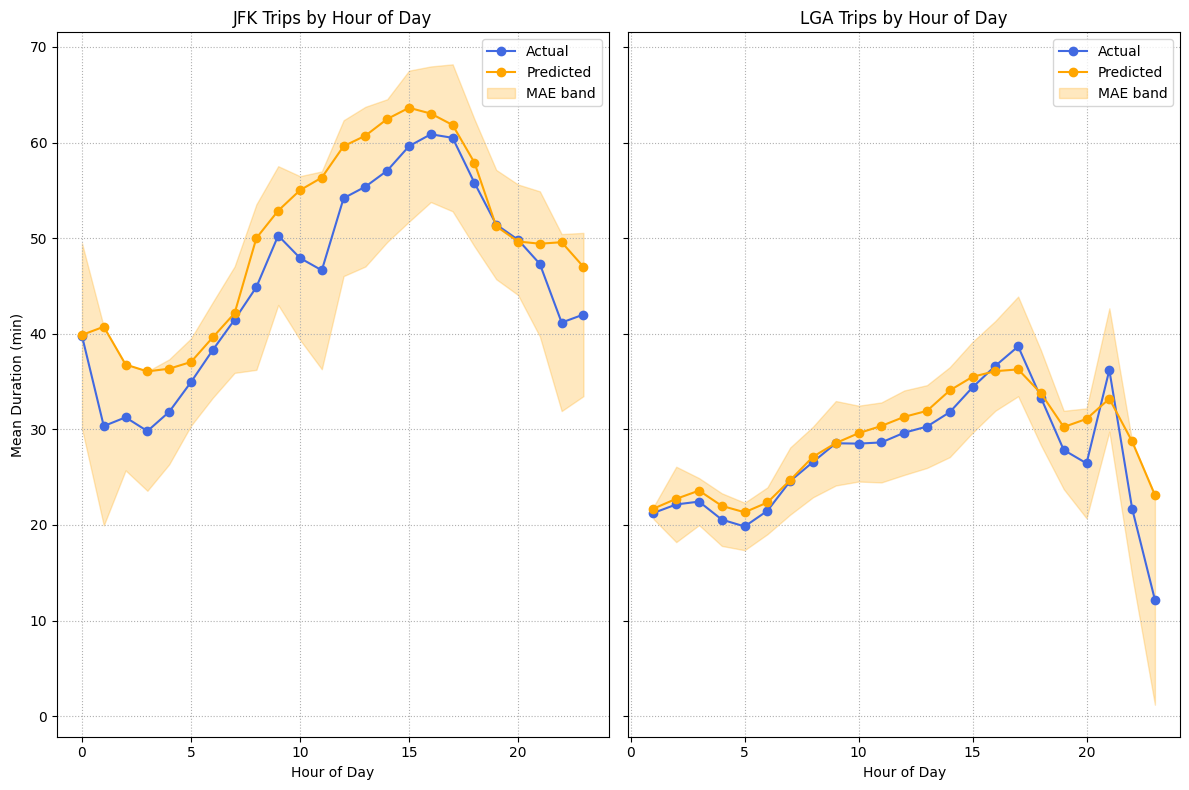

,hour,airport,actual_10th,actual_25th,actual_50th,actual_75th,actual_90th,pred_10th,pred_25th,pred_50th,pred_75th,pred_90th
0,0,JFK,23.30,38.225,44.57,45.6750,52.436,35.015335,37.730578,40.912920,41.312257,43.504486
1,1,JFK,27.93,27.930,27.93,31.5400,33.706,39.890832,40.429422,41.327071,41.327071,41.327071
3,2,JFK,25.10,25.995,32.30,33.1250,33.650,33.415987,34.156875,36.230267,37.394822,39.988476
5,3,JFK,24.25,27.300,29.75,32.7000,35.600,32.708475,34.527660,35.853990,37.238326,38.388743
7,4,JFK,25.68,27.395,30.80,35.5725,38.860,31.438462,33.904476,36.090803,37.850181,41.495027


,hour,airport,actual_10th,actual_25th,actual_50th,actual_75th,actual_90th,pred_10th,pred_25th,pred_50th,pred_75th,pred_90th
2,1,LGA,20.186,20.5850,21.250,21.9150,22.314,20.134170,20.721946,21.701573,22.681199,23.268975
4,2,LGA,15.745,17.4550,20.560,28.0400,29.490,20.460801,20.647009,22.676790,23.679406,24.825094
6,3,LGA,17.979,19.9125,22.435,24.6300,27.460,19.138029,22.145058,23.093454,25.334989,26.702328
8,4,LGA,15.253,17.6825,20.390,22.8425,25.413,17.928908,19.786315,22.361555,24.222520,25.790392
10,5,LGA,14.188,16.7300,19.870,22.6500,25.360,17.172517,18.825559,21.359430,23.815180,25.131623


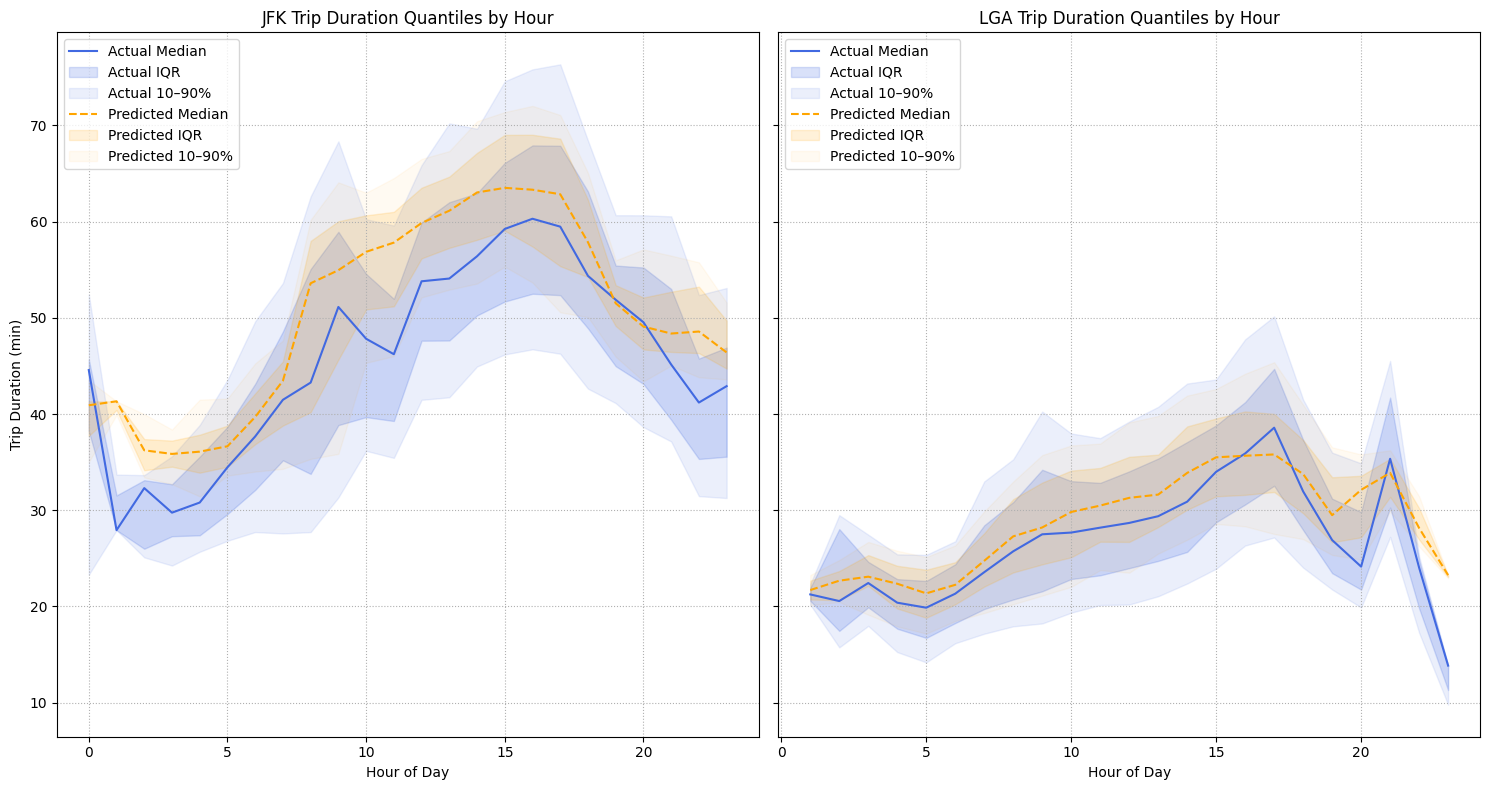

/var/folders/qk/vdr0dvt91yj5p8tdhjkrzflh0000gn/T/ipykernel_17133/3571951509.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


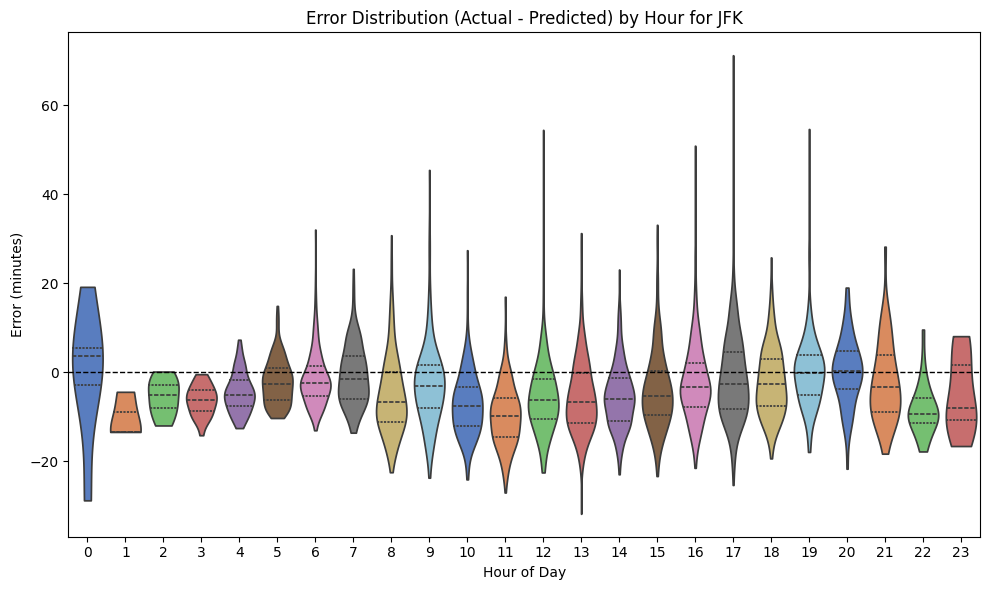

/var/folders/qk/vdr0dvt91yj5p8tdhjkrzflh0000gn/T/ipykernel_17133/3571951509.py:104: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(


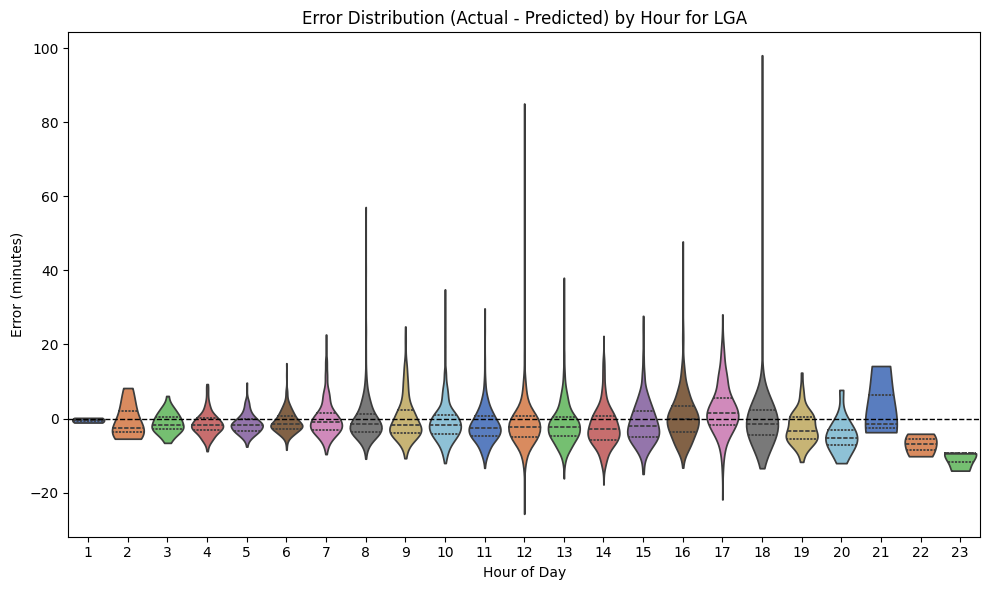

In [55]:
hour_airport_summary = (test_reg.groupby(["hour", "airport"]).agg(
    n_trips = ("duration_min", "size"),
    actual_mean = ("duration_min", "mean"),
    pred_rf = ("pred_rf", "mean"),
    mae_rf = ("abs_err_rf", "mean")
    )
    .reset_index()
    .sort_values(["airport", "hour"]))

hour_airport_summary.head(39)

fig, axes = plt.subplots(1, 2, figsize=(12, 8), sharey=True)

# Plot for JFK
hour_airport_summary_jfk = hour_airport_summary[hour_airport_summary['airport'] == 'JFK']
axes[0].plot(hour_airport_summary_jfk['hour'], hour_airport_summary_jfk['actual_mean'], label='Actual', color='royalblue', marker='o')
axes[0].plot(hour_airport_summary_jfk['hour'], hour_airport_summary_jfk['pred_rf'], label='Predicted', color='orange', marker='o')
axes[0].fill_between(
    hour_airport_summary_jfk['hour'],
    hour_airport_summary_jfk['actual_mean'] - hour_airport_summary_jfk['mae_rf'],
    hour_airport_summary_jfk['actual_mean'] + hour_airport_summary_jfk['mae_rf'],
    color='orange', alpha=0.25, label='MAE band'
)
axes[0].set_title("JFK Trips by Hour of Day")
axes[0].set_xlabel("Hour of Day")
axes[0].set_ylabel("Mean Duration (min)")
axes[0].legend()
axes[0].grid(True, linestyle=':')

# Plot for LGA
hour_airport_summary_lga = hour_airport_summary[hour_airport_summary['airport'] == 'LGA']
axes[1].plot(hour_airport_summary_lga['hour'], hour_airport_summary_lga['actual_mean'], label='Actual', color='royalblue', marker='o')
axes[1].plot(hour_airport_summary_lga['hour'], hour_airport_summary_lga['pred_rf'], label='Predicted', color='orange', marker='o')
axes[1].fill_between(
    hour_airport_summary_lga['hour'],
    hour_airport_summary_lga['actual_mean'] - hour_airport_summary_lga['mae_rf'],
    hour_airport_summary_lga['actual_mean'] + hour_airport_summary_lga['mae_rf'],
    color='orange', alpha=0.25, label='MAE band'
)
axes[1].set_title("LGA Trips by Hour of Day")
axes[1].set_xlabel("Hour of Day")
axes[1].legend()
axes[1].grid(True, linestyle=':')

plt.tight_layout()
plt.show()


# Deeper analysis: show not just the mean/MAE, but also quantiles for each hour/airport,
# and visualize the distribution (spread) of trip durations vs. predictions.

# Compute 10th, 25th, 50th (median), 75th, 90th percentiles by hour and airport
quantiles = [0.1, 0.25, 0.5, 0.75, 0.9]
def qfun(col):
    return col.quantile(quantiles)

hour_airport_quantiles = (
    test_reg.groupby(['hour','airport'])
    .agg(actual_10th=('duration_min', lambda x: x.quantile(0.1)),
         actual_25th=('duration_min', lambda x: x.quantile(0.25)),
         actual_50th=('duration_min', 'median'),
         actual_75th=('duration_min', lambda x: x.quantile(0.75)),
         actual_90th=('duration_min', lambda x: x.quantile(0.9)),
         pred_10th = ('pred_rf', lambda x: x.quantile(0.1)),
         pred_25th = ('pred_rf', lambda x: x.quantile(0.25)),
         pred_50th = ('pred_rf', 'median'),
         pred_75th = ('pred_rf', lambda x: x.quantile(0.75)),
         pred_90th = ('pred_rf', lambda x: x.quantile(0.9)),
    ).reset_index()
)
# Display a sample for JFK and LGA
display(hour_airport_quantiles[hour_airport_quantiles["airport"] == "JFK"].head(5))
display(hour_airport_quantiles[hour_airport_quantiles["airport"] == "LGA"].head(5))

# Plot quantile bands (shaded) for both actual and predicted for JFK and LGA
fig, axes = plt.subplots(1, 2, figsize=(15, 8), sharey=True)

for i, ap in enumerate(["JFK", "LGA"]):
    sub = hour_airport_quantiles[hour_airport_quantiles['airport'] == ap]
    ax = axes[i]
    # Actual durations
    ax.plot(sub['hour'], sub['actual_50th'], color='royalblue', label='Actual Median')
    ax.fill_between(sub['hour'], sub['actual_25th'], sub['actual_75th'], color='royalblue', alpha=0.2, label='Actual IQR')
    ax.fill_between(sub['hour'], sub['actual_10th'], sub['actual_90th'], color='royalblue', alpha=0.1, label='Actual 10–90%')
    # Predicted durations
    ax.plot(sub['hour'], sub['pred_50th'], color='orange', label='Predicted Median', linestyle='--')
    ax.fill_between(sub['hour'], sub['pred_25th'], sub['pred_75th'], color='orange', alpha=0.15, label='Predicted IQR')
    ax.fill_between(sub['hour'], sub['pred_10th'], sub['pred_90th'], color='orange', alpha=0.05, label='Predicted 10–90%')
    ax.set_title(f"{ap} Trip Duration Quantiles by Hour")
    ax.set_xlabel("Hour of Day")
    if i == 0:
        ax.set_ylabel("Trip Duration (min)")
    ax.legend(loc='upper left')
    ax.grid(True, linestyle=':')

plt.tight_layout()
plt.show()

# "Even deeper": plot distribution of errors (actual - pred_rf) by hour for each airport.
import seaborn as sns
for ap in ['JFK', 'LGA']:
    fig, ax = plt.subplots(figsize=(10,6))
    tmp = test_reg[test_reg['airport'] == ap]
    sns.violinplot(
        x='hour', y=(tmp['duration_min'] - tmp['pred_rf']),
        data=tmp, ax=ax, inner='quart', palette="muted", cut=0
    )
    ax.axhline(0, color='k', linestyle='--', lw=1)
    ax.set_title(f"Error Distribution (Actual - Predicted) by Hour for {ap}")
    ax.set_xlabel("Hour of Day")
    ax.set_ylabel("Error (minutes)")
    plt.tight_layout()
    plt.show()


For JFK, predicted and actual times are very tight overnight and in the early morning, with MAE usually around 4.5-6 minutes once we get past the very early hours that have only a handful of trips (0-1am). As we move into the afternoon and especially the evening rush, around 3-8pm, average trip times climb above 55–65 minutes and MAE increases to roughly 7–10 minutes. The model still tracks the overall pattern of longer trips during rush hour, but the errors widen because travel times become much more volatile once the roads fill up.

For LGA, trips are shorter and much more stable across the day. Typical average times are in the 25–35 minute range for the busy hours, and MAE usually stays around 2.5–4.5 minutes. That’s roughly a 10–15% error on a 25–35 minute trip, so the model is quite reliable for LGA, with only a small bump in error during the busiest late morning and afternoon periods.

### By Day of Week

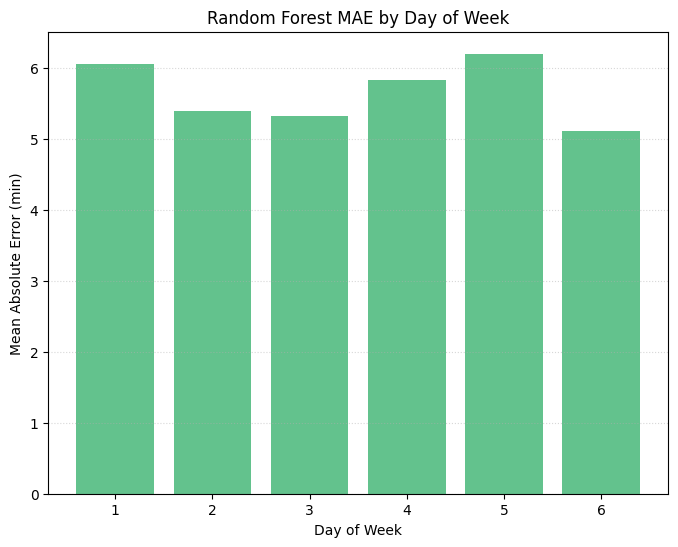

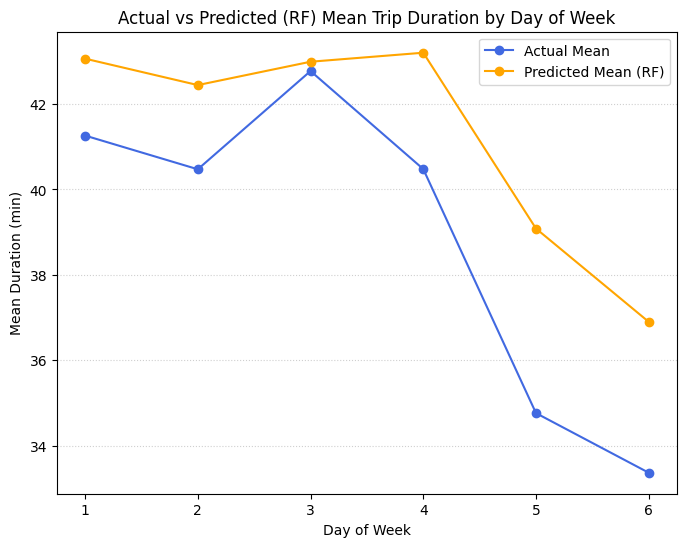

In [50]:
dow_summary = (test_reg.groupby("day_of_week").agg(
    n_trips     = ("duration_min", "size"),
    actual_mean = ("duration_min", "mean"),
    pred_rf    = ("pred_rf", "mean"),
    mae_rf     = ("abs_err_rf", "mean")
    ).reset_index().sort_values("day_of_week"))

dow_summary


import matplotlib.pyplot as plt

# Bar plot: MAE by day of week
fig, ax = plt.subplots(figsize=(8,6))
ax.bar(dow_summary['day_of_week'], dow_summary['mae_rf'], color='mediumseagreen', alpha=0.8)
ax.set_xlabel('Day of Week')
ax.set_ylabel('Mean Absolute Error (min)')
ax.set_title('Random Forest MAE by Day of Week')
ax.set_xticks(dow_summary['day_of_week'])
ax.grid(axis='y', linestyle=':', alpha=0.5)
plt.show()

# Line plot: Actual vs Predicted Mean Duration by Day of Week
fig, ax = plt.subplots(figsize=(8,6))
ax.plot(dow_summary['day_of_week'], dow_summary['actual_mean'], marker='o', label='Actual Mean', color='royalblue')
ax.plot(dow_summary['day_of_week'], dow_summary['pred_rf'], marker='o', label='Predicted Mean (RF)', color='orange')
ax.set_xlabel('Day of Week')
ax.set_ylabel('Mean Duration (min)')
ax.set_title('Actual vs Predicted (RF) Mean Trip Duration by Day of Week')
ax.legend()
ax.set_xticks(dow_summary['day_of_week'])
ax.grid(axis='y', linestyle=':', alpha=0.6)
plt.show()


The model is pretty stable across days, with the average error staying roughly in the 5–6.5 minute range. Lower-traffic days tend to be a bit faster and slightly easier to predict, while heavier weekday commute days show slightly higher error, but there are no big swings in performance from one day to another.

### Zone Model Performance 

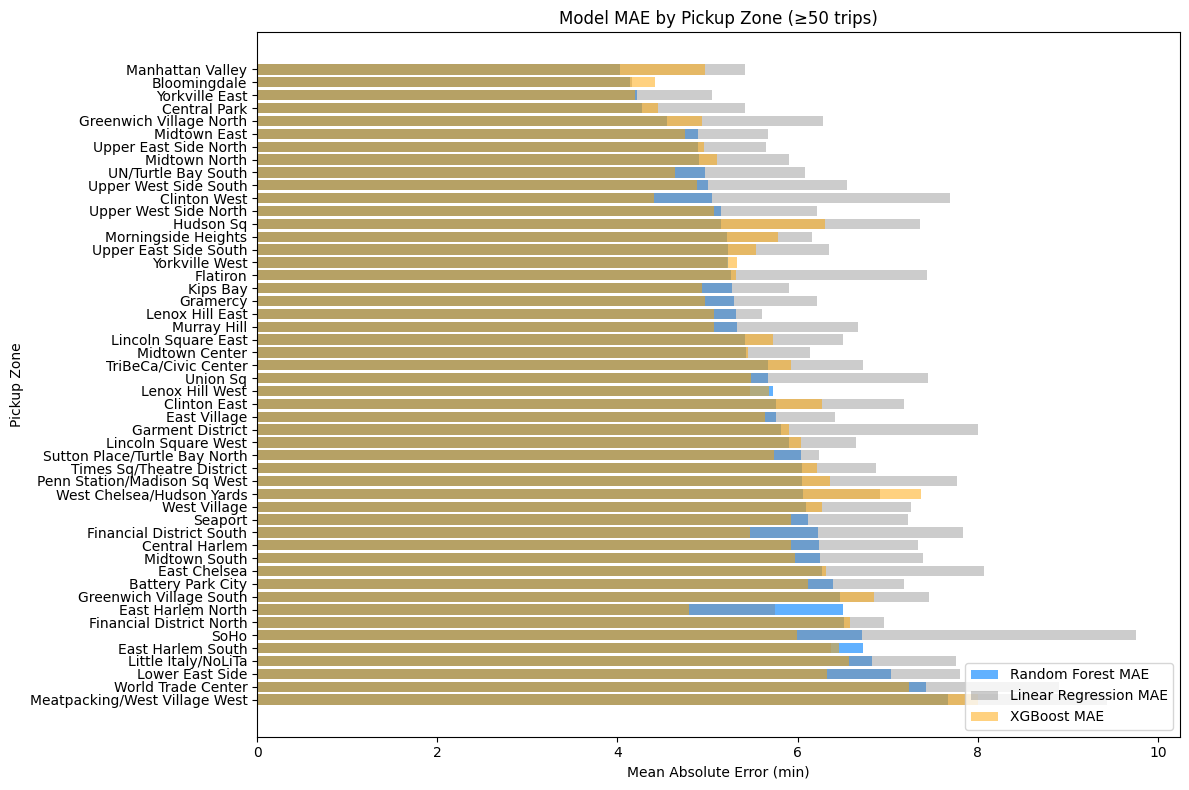

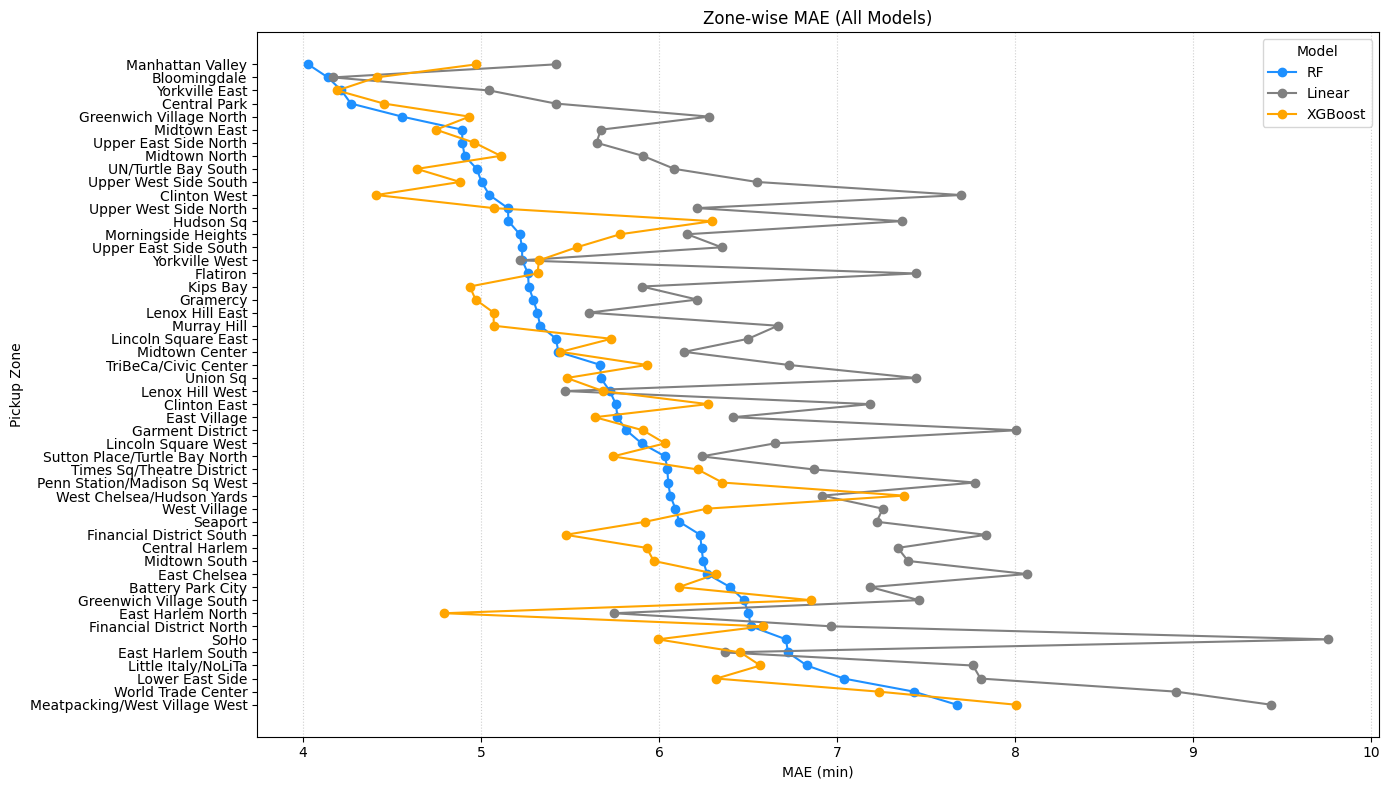

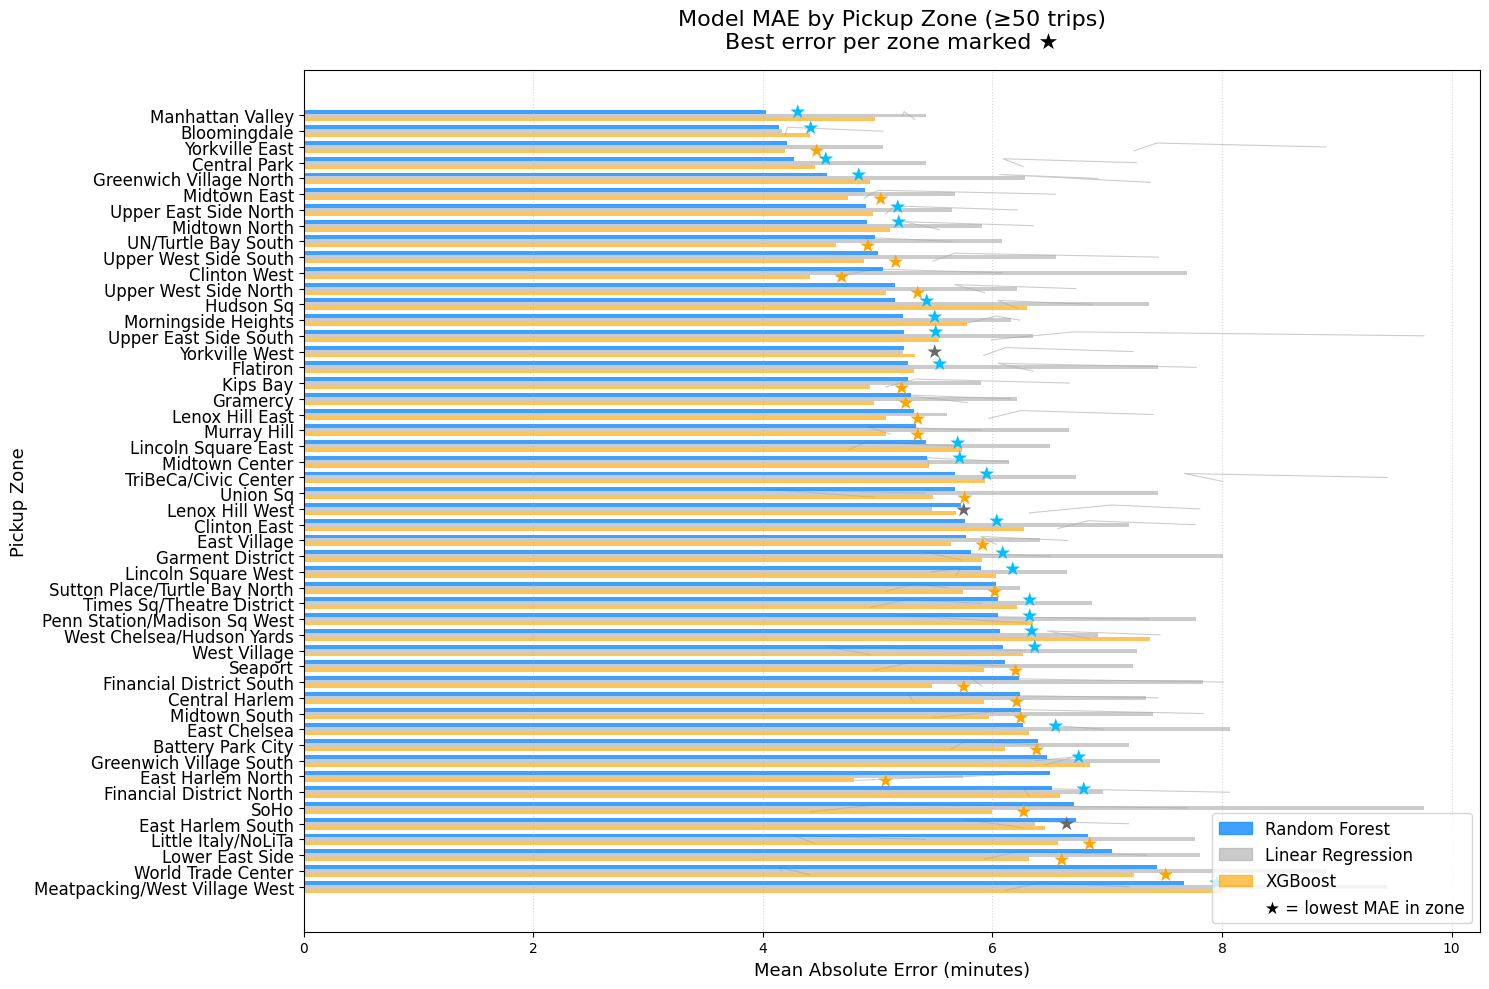

In [53]:
zone_model_perf = (test_reg.groupby("pickup_zone").agg(
    n_trips   = ("duration_min", "size"),
    mae_lin   = ("abs_err_lin", "mean"),
    mae_rf    = ("abs_err_rf", "mean"),
    mae_xgb   = ("abs_err_xgb", "mean")
    )
    .query("n_trips >= 25")
    .reset_index()
)

zone_model_perf.head(69)

# --- Visualize Model Performance by Pickup Zone ---

fig, ax = plt.subplots(figsize=(12,8))

zones_sorted = zone_model_perf.sort_values("mae_rf", ascending=False)

ax.barh(zones_sorted["pickup_zone"], zones_sorted["mae_rf"], color="dodgerblue", alpha=0.7, label="Random Forest MAE")
ax.barh(zones_sorted["pickup_zone"], zones_sorted["mae_lin"], color="gray", alpha=0.4, label="Linear Regression MAE")
ax.barh(zones_sorted["pickup_zone"], zones_sorted["mae_xgb"], color="orange", alpha=0.5, label="XGBoost MAE")

ax.set_xlabel("Mean Absolute Error (min)")
ax.set_ylabel("Pickup Zone")
ax.set_title("Model MAE by Pickup Zone (≥50 trips)")
ax.legend(loc="lower right")
plt.tight_layout()
plt.show()

# --- Compare all 3 models zone-by-zone with lines/points ---

fig, ax = plt.subplots(figsize=(14,8))

y = np.arange(len(zones_sorted))
ax.plot(zones_sorted["mae_rf"], y, marker="o", label="RF", color="dodgerblue")
ax.plot(zones_sorted["mae_lin"], y, marker="o", label="Linear", color="gray")
ax.plot(zones_sorted["mae_xgb"], y, marker="o", label="XGBoost", color="orange")

ax.set_yticks(y)
ax.set_yticklabels(zones_sorted["pickup_zone"])
ax.set_xlabel("MAE (min)")
ax.set_ylabel("Pickup Zone")
ax.set_title("Zone-wise MAE (All Models)")
ax.legend(title="Model")
ax.grid(axis='x', linestyle=':', alpha=0.6)
plt.tight_layout()
plt.show()



# --- Enhanced Visual: Model MAE comparison by pickup zone (with differences) ---

import matplotlib.patches as mpatches

fig, ax = plt.subplots(figsize=(15,10))

zones_sorted = zone_model_perf.sort_values("mae_rf", ascending=False)
y = np.arange(len(zones_sorted))

# Bars by model (each offset)
bar_height = 0.25
ax.barh(y + bar_height, zones_sorted["mae_rf"], height=bar_height, color="dodgerblue", label="Random Forest MAE", alpha=0.85)
ax.barh(y, zones_sorted["mae_lin"], height=bar_height, color="darkgray", label="Linear Regression MAE", alpha=0.6)
ax.barh(y - bar_height, zones_sorted["mae_xgb"], height=bar_height, color="orange", label="XGBoost MAE", alpha=0.65)

# Annotate best MAE for each zone
min_mae = zones_sorted[["mae_rf", "mae_lin", "mae_xgb"]].min(axis=1)
for idx, (rf, lin, xgb, min_err) in enumerate(zip(zones_sorted["mae_rf"], zones_sorted["mae_lin"], zones_sorted["mae_xgb"], min_mae)):
    # Mark best MAE with a star
    if min_err == rf:
        ax.text(rf + 0.2, idx + bar_height, "★", va="center", ha="left", fontsize=14, color="deepskyblue")
    elif min_err == lin:
        ax.text(lin + 0.2, idx, "★", va="center", ha="left", fontsize=14, color="dimgray")
    elif min_err == xgb:
        ax.text(xgb + 0.2, idx - bar_height, "★", va="center", ha="left", fontsize=14, color="orange")

# Connect models for each zone to show spread
for i, row in zones_sorted.iterrows():
    xvals = [row["mae_lin"], row["mae_rf"], row["mae_xgb"]]
    yvals = [y[i], y[i]+bar_height, y[i]-bar_height]
    ax.plot(xvals, yvals, color='black', linewidth=0.8, alpha=0.2, zorder=0)

ax.set_yticks(y)
ax.set_yticklabels(zones_sorted["pickup_zone"], fontsize=12)
ax.set_xlabel("Mean Absolute Error (minutes)", fontsize=13)
ax.set_ylabel("Pickup Zone", fontsize=13)
ax.set_title("Model MAE by Pickup Zone (≥50 trips)\nBest error per zone marked ★", fontsize=16, pad=16)
ax.grid(axis='x', linestyle=':', alpha=0.5)

# Custom handles with color match
handles = [
    mpatches.Patch(color="dodgerblue", alpha=0.85, label="Random Forest"),
    mpatches.Patch(color="darkgray", alpha=0.6, label="Linear Regression"),
    mpatches.Patch(color="orange", alpha=0.65, label="XGBoost"),
    mpatches.Patch(color="white", label="★ = lowest MAE in zone"),
]
ax.legend(handles=handles, loc="lower right", fontsize=12)
plt.tight_layout()
plt.show()





By pickup zone, Random Forest generally gives the most accurate predictions. In most Manhattan zones the RF MAE is slightly lower than linear regression and XGBoost, often shaving about 0.5–1 minute off the average error (Central Park, Midtown East, Murray Hill, Upper East/West). All three models are reasonably close in the calmer neighborhoods (Yorkville, Kips Bay, Gramercy), where MAE is around 4–5 minutes, and they struggle more in busy, variable areas like Meatpacking, Midtown South, SoHo, Times Square, and the World Trade Center, where MAE creeps up toward 7–8 minutes regardless of model.